# Analysis of FTS transfer error messages

**Objective:** 

 - extract FTS transfer error data
 - explore the data
 - apply NLP methods to error messages
 - possibly account for other features as well (e.g. source/destination sites, tansferprotocol, ...)
 - perform clustering analysis

### Spark Session 

In [1]:
%%time

# start Spark Session
from pyspark.sql import SparkSession

spark = SparkSession.builder.master("local[*]").appName("fts_data_extraction").getOrCreate()
#spark = SparkSession.builder.master("local[*]").appName("fts_data").getOrCreate()
spark

CPU times: user 41.8 ms, sys: 25 ms, total: 66.7 ms
Wall time: 7.56 s


## Import data

**Note:** the period 7/10 - 10/10 is considered since there should be an issue with an FTS instance and we want our approach to be able to spot it.

In [2]:
%%time 

# FTS data path
path_list = ['/project/monitoring/archive/fts/raw/complete/2019/10/{:0>2}/*'.format(i) for i in range(7,11)]

# load the data in the json file
all_transfers = spark.read.json(path_list)

CPU times: user 368 ms, sys: 102 ms, total: 470 ms
Wall time: 4min 10s


### Basic exploration 

The DataFrame obtained is a combination of two DataFrames, one containing the actual data and one the metadata. Thus, we extract just the data part since metadata are not so relevant to our scope:

In [3]:
# retrieve just data 
all_transfers_data = all_transfers.select("data.*")

all_transfers_data.printSchema()

root
 |-- activity: string (nullable = true)
 |-- block_size: long (nullable = true)
 |-- buf_size: long (nullable = true)
 |-- channel_type: string (nullable = true)
 |-- chk_timeout: long (nullable = true)
 |-- dest_srm_v: string (nullable = true)
 |-- dst_hostname: string (nullable = true)
 |-- dst_se: string (nullable = true)
 |-- dst_site_name: string (nullable = true)
 |-- dst_url: string (nullable = true)
 |-- endpnt: string (nullable = true)
 |-- f_size: long (nullable = true)
 |-- file_id: string (nullable = true)
 |-- file_size: long (nullable = true)
 |-- final_destination: string (nullable = true)
 |-- ipv6: boolean (nullable = true)
 |-- is_recoverable: boolean (nullable = true)
 |-- job_id: string (nullable = true)
 |-- job_state: string (nullable = true)
 |-- latency: long (nullable = true)
 |-- log_link: string (nullable = true)
 |-- nstreams: long (nullable = true)
 |-- operation_time: long (nullable = true)
 |-- remote_access: boolean (nullable = true)
 |-- retry: lon

In [1]:
'''%%time

n_trans = all_transfers_data.count()
n_vars = len(all_transfers_data.columns)

print("FTS transfer dataset shape:", n_trans, n_vars)
'''

'%%time\n\nn_trans = all_transfers_data.count()\nn_vars = len(all_transfers_data.columns)\n\nprint("FTS transfer dataset shape:", n_trans, n_vars)\n'

The dataset of all transfers attempted between 7/10 and 10/10 is made of ~17.5MLN rows and 68 columns. Let us now have a closer look into the variables and their meaning:

### Variables' description

<div class="alert alert-block alert-danger">
<b>Reminder:</b> Check variable relevance to error detection with domain experts and then i) shorten the list (only relevant features with explanations), ii) add reference to documentation, iii) add legend with message/auxiliary variable colors. 
</div>


The following list contains a description of the variables' content:

**Generic information:**

  - "tr_id": "YEAR-MONTH-DAY-HOURMINUTE__sourcese__destse__file_id__job_id",
  - "endpnt": "FTS3 endpoint",
  - "src_srm_v": "Source SRM version, always 2.0 if srm is used",
  - "dest_srm_v": "Destination SRM version, always 2.0 if srm is used",
  - **<font color='green'>"vo"</font>:** "Virtual Organization",
  - "src_url": "Source URL",
  - "dst_url": "Destination URL",
  - **<font color='green'>"src_hostname"</font>:** "Source hostname",
  - **<font color='green'>"dst_hostname"</font>:** "Destination hostname",
  - "src_site_name": "", // Always empty
  - "dst_site_name": "", // Always empty
  - **<font color='green'>"t_channel"</font>:** "source_protocol://source_host__dest_protocol://dest_host",

**Time information:**
  - "timestamp_tr_st": 0, // Timestamp of the whole process start, in milliseconds
  - **<font color='green'>"timestamp_tr_comp"</font>:** 0, // Timestamp of the whole process completion, in milliseconds
  - "timestamp_chk_src_st": 0, // Timestamp when started the validation of the source checksum, in milliseconds
  - "timestamp_chk_src_ended": 0, // Timestamp when finished the validation of the source checksum, in milliseconds
  - "timestamp_checksum_dest_st": 0, // Timestamp when started the validation of the destination checksum, in milliseconds
  - "timestamp_checksum_dest_ended": 0, // Timestamp when finished the validation of the destination checksum, in milliseconds
  - "t_timeout": 0, // Timeout used for the transfer
  - "chk_timeout": 0, // Timeout used for the checksum operations

**Error informations:**
  - **<font color='red'>"t_error_code"</font>:** 0, // Error code: an errno value (i.e. ENOENT)
  
  > corresponds to the errno value returned by the url-copy process (i.e. ENOENT)
  
  - **<font color='red'>"tr_error_scope"</font>:** "Error scope, empty if ok",
  
  > 3 possible values, SOURCE, TRANSFER and DESTINATION depending on where the error happens. SOURCE for instance is set if the source file is not there or the source checksum query fails.
  
  - **<font color='red'>"t_failure_phase"</font>:** "Error phase, empty of ok",
  
  > 3 possible values TRANSFER_PREPARATION, TRANSFER, TRANSFER_FINALIZATION ( more or less they map to the values of tr_error_scope)
  
  - **<font color='red'>"tr_error_category"</font>:** "Error category, empty if ok",
  
  > this is the string representation of the t_error_code as returned by the strerror_r function (https://linux.die.net/man/3/strerror_r), possible values are:
COMMUNICATION_ERROR_ON_SEND, FILE_EXIST, PERMISSION_DENIED, etc

  - **<font color='red'>"t_final_transfer_state"</font>:** "Ok|Error|Abort",

  > != "Ok" for errors

  - **<font color='red'>"t__error_message"</font>:** "Error message, empty if ok",
  
  > string error from the storage



**Transfer metrics:**
  - "tr_bt_transfered": 0, // How many bytes have been transferred
  - "nstreams": 0, // How many streams have been used
  - "buf_size": 0, // TCP buffer size used (for backwards compatibility)
  - "tcp_buf_size": 0, // TCP buffer size used
  - "block_size": 0, // Unused

  - "f_size"  0, // Filesize

  - "time_srm_prep_st": 0, // Timestamp of the start of the SRM GET operation, if any, in milliseconds
  - "time_srm_prep_end": 0, // Timestamp of the completion of the SRM GET operation, if any, in milliseconds
  - "time_srm_fin_st": 0, // Timestamp of the start of the SRM PUT operation, if any, in milliseconds
  - "time_srm_fin_end": 0, // Timestamp of the completion of the SRM PUT operation, if any, in milliseconds

  - "srm_space_token_src": "Source space token, if any",
  - "srm_space_token_dst": "Destination space token, if any",

  - "tr_timestamp_start": 0, // Timestamp of the start of *only the transfer part* (excluding preparation), in milliseconds
  - "tr_timestamp_complete": 0, // Timestamp of the completion of *only the transfer part* (excluding preparation), in milliseconds


  - "channel_type": "urlcopy", // Always
  - "user_dn": "User that submitted the job",
  - "file_metadata": "File metadata set by the user at submission",
  - "job_metadata": "Job metadata set by the user at submission"


  - "retry": 0, // When retries are enabled, which retry is this transfer
  - "retry_max": 0, // When retries are enabled, max number of retries for this transfer
  - "job_m_replica": false, // true if this transfer belongs to a multiple replica job
  - "job_state": "Job state, if known",
  - "is_recoverable": false, // true if FTS3 considers this transfer could be retried (depends on the error code)
  - "ipv6": false, // true if the transfer took place over IPv6
  - "transfer_type": "streamed|3rd pull|3rd push" // How the transfer was done

<div class="alert alert-block alert-danger">
<b>Alert:</b> Some of the variables are not documented!
    
 't_final_transfer_state_flag',
 'file_id',
 'file_size',
 'activity',
 'timestamp_checksum_src_diff',
 'final_destination',
 'srm_finalization_time',
 'job_id',
 'timestamp_checksum_dst_diff',
 'src_se',
 'throughput',
 'operation_time',
 'srm_preparation_time',
 'srm_overhead_percentage',
 'srm_overhead_time',
 'log_link',
 'remote_access',
 'user',
 'latency',
 'dst_se'
 
</div>

### Error extraction

Now we focus on transfer errors only and split the DataFrame in multiple tables with similar pieces of information:

In [4]:
errors = all_transfers_data.filter(all_transfers_data["t_final_transfer_state_flag"] == 0)

In [5]:
n_errs = errors.count()
n_errs

4716431

### **Messages**

In [22]:
spark.sparkContext.uiWebUrl

'http://fd1182a52b46:5201'

#### Unique messages 

In [23]:
error_freq = errors.groupBy("t__error_message").count()
error_freq = error_freq.orderBy(error_freq["count"].desc()).withColumn("percentage", error_freq["count"]/n_errs*100)

windowval = (Window.orderBy(error_freq['count'].desc()).rangeBetween(Window.unboundedPreceding, 0))

error_freq = error_freq.withColumn('cum_perc', F.sum('percentage').over(windowval)).withColumn("msg_id", F.monotonically_increasing_id())
error_freq = error_freq.withColumnRenamed("t__error_message", "message").select("msg_id", "message", "count", "percentage", "cum_perc")

error_freq = error_freq.orderBy(error_freq['count'].desc())

In [24]:
%%time
pd_distinct_mess = error_freq.toPandas()
pd_distinct_mess.head()

CPU times: user 2.69 s, sys: 259 ms, total: 2.95 s
Wall time: 4min 32s


,msg_id,message,count,percentage,cum_perc
0,0,TRANSFER globus_ftp_client: the server responded with an error 500 500-Command failed. : System error in open: No such file or directory 500-A system call failed: No such file or directory 500 End.,570137,12.088314,12.088314
1,1,"TRANSFER globus_ftp_control: gss_init_sec_context failed GSS Major Status: Unexpected Gatekeeper or Service Name globus_gsi_gssapi: Authorization denied: The name of the remote entity (/DC=EU/DC=EGI/C=ZA/O=Hosts/O=University of Cape Town/CN=dtn.ilifu.ac.za), and the expected name for the remote entity (/CN=dtn.ilifu.ac.za) do not match",324553,6.881326,18.969640
2,2,Error on XrdCl::CopyProcess::Run(): [ERROR] Server responded with an error: [3010] Write permission denied,224141,4.752343,23.721984
3,3,DESTINATION SRM_PUT_TURL error on the turl request : [SE][StatusOfPutRequest][SRM_EXCEED_ALLOCATION] Space associated with the space token 2310037 is not enough to hold SURL.,115402,2.446808,26.168792
4,4,TRANSFER an end-of-file was reached globus_xio: An end of file occurred,113417,2.404721,28.573512


#### Unique tr_error_category 

In [6]:
%%time

from pyspark.sql import Window
from pyspark.sql import functions as F

error_freq = errors.groupBy("tr_error_category").count()
error_freq = error_freq.orderBy(error_freq["count"].desc()).withColumn("percentage", error_freq["count"]/n_errs*100)

windowval = (Window.orderBy(error_freq['count'].desc()).rangeBetween(Window.unboundedPreceding, 0))

error_freq = error_freq.withColumn('cum_perc', F.sum('percentage').over(windowval)).withColumn("msg_id", F.monotonically_increasing_id())
error_freq = error_freq.withColumnRenamed("tr_error_category", "category").select("msg_id", "category", "count", "percentage", "cum_perc")

error_freq = error_freq.orderBy(error_freq['count'].desc())

CPU times: user 26 ms, sys: 5.35 ms, total: 31.4 ms
Wall time: 187 ms


In [7]:
pd_distinct_err_cat = error_freq.toPandas()
pd_distinct_err_cat

,msg_id,category,count,percentage,cum_perc
0,0,COMMUNICATION_ERROR_ON_SEND,1736678,36.821868,36.821868
1,1,NO_SUCH_FILE_OR_DIRECTORY,1180219,25.023561,61.845429
2,2,PERMISSION_DENIED,667872,14.160538,76.005967
3,3,CONNECTION_TIMED_OUT,240245,5.093788,81.099755
4,4,INPUT/OUTPUT_ERROR,187725,3.980234,85.079990
5,5,NO_MESSAGE_OF_DESIRED_TYPE,140743,2.984100,88.064089
6,6,PROTOCOL_NOT_SUPPORTED,128317,2.720638,90.784727
7,7,DISK_QUOTA_EXCEEDED,115561,2.450179,93.234906
8,8,FILE_EXISTS,112961,2.395053,95.629958
9,9,NO_SPACE_LEFT_ON_DEVICE,101843,2.159323,97.789282


In [8]:
n_cat = 10
top_n_cat = pd_distinct_err_cat.category.head(10)

top_n_cat

0    COMMUNICATION_ERROR_ON_SEND
1      NO_SUCH_FILE_OR_DIRECTORY
2              PERMISSION_DENIED
3           CONNECTION_TIMED_OUT
4             INPUT/OUTPUT_ERROR
5     NO_MESSAGE_OF_DESIRED_TYPE
6         PROTOCOL_NOT_SUPPORTED
7            DISK_QUOTA_EXCEEDED
8                    FILE_EXISTS
9        NO_SPACE_LEFT_ON_DEVICE
Name: category, dtype: object

#### Unique High Level Group 

Try to parse the message strings to get the informative part at the beginning:

In [12]:
def strip_paths(string, max_len = 20):
    '''Take a string and eliminate path/url (i.e. tokens longer than max_len)'''
    tks = [x for x in string.split() if len(x)<max_len]
    return(' '.join(tks))

def high_level_grouping_str(error_str, max_len = 7, max_len_tokens=30):
    '''Take an error string and return the meaningful description from the beginning of the message'''
    import re

    # strip paths
    error_col = strip_paths(error_str, max_len_tokens) 

    # extract group/subgroup
    grouping = error_col.split(": ")[0]
    
    # reduce long strings (>max_len tokens)
    try:
        grouping = ' '.join(grouping.split()[:max_len])
    except:
        grouping = ' '.join(grouping.split())
        
                        
    # take only capital tokens for long messages and take all for short ones
    if len(grouping.split())>(max_len-1):
        grouping = re.findall(r'\b[A-Z]+_?[A-Z]+_?[A-Z]+_?[A-Z]+\b', grouping)        
                            
    # join list elements to get a string
    if type(grouping)==type(list()):
        grouping = ' '.join(grouping)
                        
    return(grouping)

In [13]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

# transform in user defined function
high_level_grouping_udf = udf(high_level_grouping_str, StringType())

# create high level groups
errors = errors.withColumn("hlg", high_level_grouping_udf("t__error_message"))

# compute
error_freq = errors.groupBy("hlg").count()
error_freq = error_freq.orderBy(error_freq["count"].desc()).withColumn("percentage", error_freq["count"]/n_errs*100)

windowval = (Window.orderBy(error_freq['count'].desc()).rangeBetween(Window.unboundedPreceding, 0))

error_freq = error_freq.withColumn('cum_perc', F.sum('percentage').over(windowval)).withColumn("msg_id", F.monotonically_increasing_id())
error_freq = error_freq.withColumnRenamed("hlg", "high_level_group").select("msg_id", "high_level_group", "count", "percentage", "cum_perc")

error_freq = error_freq.orderBy(error_freq['count'].desc())


In [14]:
%%time
pd_distinct_hlg = error_freq.toPandas()
pd_distinct_hlg

CPU times: user 441 ms, sys: 134 ms, total: 575 ms
Wall time: 4min 55s


,msg_id,high_level_group,count,percentage,cum_perc
0,0,TRANSFER globus_ftp_client,1305287,27.675312,27.675312
1,1,Error on XrdCl::CopyProcess::Run(),564591,11.970725,39.646037
2,2,srm-ifce err,480659,10.191159,49.837197
3,3,DESTINATION SRM_PUTDONE,373385,7.916685,57.753882
4,4,TRANSFER globus_ftp_control,331525,7.029150,64.783032
5,5,globus_ftp_client,192425,4.079886,68.862918
6,6,TRANSFER ERROR,181285,3.843690,72.706608
7,7,DESTINATION SRM_PUT_TURL,144295,3.059411,75.766019
8,8,Protocol not supported or path/url invalid:,126173,2.675180,78.441198
9,9,Error reported from srm_ifce,120969,2.564842,81.006040


<div class="alert alert-block alert-warning">
<b>Alert:</b> There are 86062 messages that are not dealt with properly by the high_level_grouping_udf function and, thus, result in missing values of hlg. More detailed information on the <b>14 unique strings</b> are reported below:
</div>

In [18]:
missing = errors.filter(errors.hlg=="").select("t__error_message")
pd_missing = missing.toPandas()

In [21]:
import pandas as pd
pd.set_option('display.max_colwidth', -1)

pd_missing.t__error_message.unique()

array(['Destination file exists and overwrite is not enabled',
       'Checksum value required if mode is not end to end',
       'User and source checksums do not match',
       'Source and destination checksums do not match',
       'User and destination checksums do not match',
       'Failed to stat file (No such file or directory)',
       '[gfal2_stat][gfal_plugin_statG][gfal_xrootd_statG] Failed to stat file (No such file or directory)',
       'Result Could not connect to server after 1 attempts',
       'Failure Authentication error, reached maximum number of attempts after 1 attempts',
       'Result Domain name resolution failed after 1 attempts',
       '[gfal2_stat][gfal_plugin_statG][davix2gliberr] Result Domain name resolution failed after 1 attempts',
       'Failed to stat file (No route to host)',
       '[gfal2_stat][gfal_plugin_statG][davix2gliberr] Result Could not connect to server after 1 attempts',
       '[gfal2_stat][gfal_plugin_statG][davix2gliberr] Result Au

In [26]:
print("The total number of errors tracked between 7/10 and 10/10 is:", n_errs)
print("The number of unique messages is:", pd_distinct_mess.shape[0])
print("The number of unique high level groups (parsing) is:", pd_distinct_hlg.shape[0])
print("The number of unique categories (FTS) is:", pd_distinct_err_cat.shape[0])

The total number of errors tracked between 7/10 and 10/10 is: 4716431
The number of unique messages is: 271795
The number of unique high level groups (parsing) is: 88
The number of unique categories (FTS) is: 27


#### Save relevant insights

In [45]:
!pwd

/eos/home-l/lclissa/SWAN_projects/rucio-log-clustering/notebooks


In [48]:
# save summary statistics 
pd_distinct_mess.to_csv("t__error_message_stats.csv", index=False)
pd_distinct_err_cat.to_csv("tr_error_category_stats.csv", index=False)
pd_distinct_hlg.to_csv("hlg_stats.csv", index=False)

In [60]:
# save missing high level groups
import numpy as np

np.savetxt("missing_hlg.csv", pd_missing.t__error_message.unique(), header="message missing_hlg", fmt=('%s'))

##### Clean up environment

In [61]:
%who

F	 SparkSession	 StringType	 Window	 a	 all_transfers	 all_transfers_data	 dist_mess_1	 error_freq	 
errors	 high_level_grouping_str	 high_level_grouping_udf	 missing	 n_cat	 n_errs	 np	 path_list	 pd	 
pd_dist_mess_1	 pd_distinct_err_cat	 pd_distinct_hlg	 pd_distinct_mess	 pd_missing	 selected_category	 spark	 strip_paths	 top_n_cat	 
udf	 windowval	 


In [62]:
del (all_transfers, all_transfers_data, error_freq, path_list, n_cat, top_n_cat, windowval, Window, high_level_grouping_str,
     high_level_grouping_udf, missing, pd_missing)

## Tokenization/Vectorization testing

Starting directly from the whole dataset would be too much. In fact, experimenting with different tokenization/vectorization strategies would take longer and, most of all, going through the results to assess how well it works would be very boring and time consuming.

In the following I focus only on messages belonging to the most popular **tr_error_category**, i.e. *COMMUNICATION_ERROR_ON_SEND*.

##### How many unique messages in the most popular tr_error_category? 

In [31]:
selected_category = "COMMUNICATION_ERROR_ON_SEND"

dist_mess_1 = errors.filter("tr_error_category == '{}' ".format(selected_category)).select("t__error_message", "hlg")

pd_dist_mess_1 = dist_mess_1.toPandas()
pd_dist_mess_1.t__error_message.unique()
# 173920

array(['SOURCE CHECKSUM globus_ftp_client: the server responded with an error 500 error: commands denied   ',
       'TRANSFER  globus_ftp_client: the server responded with an error 500 500-System error in mkdir: Transport endpoint is not connected  500-A system call failed: Transport endpoint is not connected  500 End.   ',
       'TRANSFER  globus_xio: Unable to connect to starsky.nikhef.nl:2811 globus_xio: System error in connect: Connection timed out globus_xio: A system call failed: Connection timed out ',
       ...,
       'TRANSFER  globus_ftp_client: the server responded with an error 451 General problem: Problem while connected to [2620:0:210:1::f1]:20898: ClosedChannelException   ',
       'TRANSFER  globus_ftp_client: the server responded with an error 451 General problem: Problem while connected to [2620:0:210:1::e4]:34923: ClosedChannelException   ',
       'TRANSFER  globus_ftp_client: the server responded with an error 451 General problem: Problem while connected to [26

In [43]:
print("The total number of error messages belonging to {} category is {}.".format(selected_category, pd_dist_mess_1.shape[0]))

print("\nThere are {} unique error messages in this error category.".format(len(pd_dist_mess_1.t__error_message.unique())))
print("These belong to {} different high level groups (parsing).".format(len(pd_dist_mess_1.hlg.unique())))

The total number of error messages belonging to COMMUNICATION_ERROR_ON_SEND category is 1736678.

There are 173920 unique error messages in this error category.
These belong to 29 different high level groups (parsing).


##### Let us have a closer look 

In [35]:
pd_dist_mess_1.head(70)

(1736678, 2)


,t__error_message,hlg
0,SOURCE CHECKSUM globus_ftp_client: the server responded with an error 500 error: commands denied,SOURCE CHECKSUM globus_ftp_client
1,TRANSFER globus_ftp_client: the server responded with an error 500 500-System error in mkdir: Transport endpoint is not connected 500-A system call failed: Transport endpoint is not connected 500 End.,TRANSFER globus_ftp_client
2,TRANSFER globus_xio: Unable to connect to starsky.nikhef.nl:2811 globus_xio: System error in connect: Connection timed out globus_xio: A system call failed: Connection timed out,TRANSFER globus_xio
3,TRANSFER globus_ftp_client: the server responded with an error 500 500-Command failed. : globus_xio: Unable to connect to 2001:1470:FF8A:6D:DC:0:0:2:20870 500-globus_xio: System error in connect: Connection timed out 500-globus_xio: A system call failed: Connection timed out 500- 500 End.,TRANSFER globus_ftp_client
4,SOURCE CHECKSUM globus_ftp_client: the server responded with an error 500 Command failed : error: commands denied,SOURCE CHECKSUM globus_ftp_client
5,TRANSFER an end-of-file was reached globus_xio: An end of file occurred,TRANSFER an end-of-file was reached globus_xio
6,"DESTINATION OVERWRITE srm-ifce err: Communication error on send, err: [SE][srmRm][] httpg://tbn18.nikhef.nl:8446/srm/managerv2: CGSI-gSOAP running on fts706.cern.ch reports could not open connection to tbn18.nikhef.nl:8446",DESTINATION OVERWRITE srm-ifce err
7,"DESTINATION OVERWRITE srm-ifce err: Communication error on send, err: [SE][srmRm][] httpg://tbn18.nikhef.nl:8446/srm/managerv2: CGSI-gSOAP running on fts706.cern.ch reports could not open connection to tbn18.nikhef.nl:8446",DESTINATION OVERWRITE srm-ifce err
8,SOURCE CHECKSUM globus_ftp_client: the server responded with an error 500 error: commands denied,SOURCE CHECKSUM globus_ftp_client
9,TRANSFER an end-of-file was reached globus_xio: An end of file occurred,TRANSFER an end-of-file was reached globus_xio


<div class="alert alert-block alert-info">
    <b>Note:</b> Picking the set of messages falling under the most popular <i>tr_error_category</i> seems a good compromise between starting from a smaller subset of data and still having good variability to challenge the model's discriminant power.
</div>

### Tokenization

In order to test tokenization strategies I start from one message per high level group so to see how it works for each typology:

In [74]:
# Note: data are contained in pyspark dataframe dist_mess_1

# I take the last string in lexicographic order per hlg group. The assumption is that strings in each 
# group differ just by sets of parameters as error code, paths/urls, site names, protocol, ...
test_messages = dist_mess_1.groupBy("hlg").agg({"t__error_message": "max"}).withColumnRenamed("max(t__error_message)", "message")

# I cache the dataframe to have fast access. Given the small size I could transform it into pandas
# but I want to test tokenization on pyspark dataframes to generalise the code
test_messages.cache()

DataFrame[hlg: string, message: string]

In [75]:
test_messages.toPandas()

,hlg,message
0,SOURCE CHECKSUM globus_xio,SOURCE CHECKSUM globus_xio: Unable to connect to stor71.datagrid.cea.fr:2811 globus_xio: System error in connect: Connection refused globus_xio: A system call failed: Connection refused
1,DESTINATION SRM_PUTDONE,DESTINATION SRM_PUTDONE Error on the surl srm://tbit00.nipne.ro/dpm/nipne.ro/home/atlas/atlasdatadisk/rucio/tests/f1/83/ESD.2c086b8f2ce441768d20b23096974d31 while putdone : [SE][PutDone][SRM_INTERNAL_ERROR] <none>
2,SOURCE CHECKSUM,SOURCE CHECKSUM an end-of-file was reached globus_xio: An end of file occurred
3,DESTINATION SRM_PUT_TURL srm-ifce err,"DESTINATION SRM_PUT_TURL srm-ifce err: Communication error on send, err: [SE][StatusOfPutRequest][] httpg://tech-se.hep.technion.ac.il:8444/srm/managerv2: CGSI-gSOAP running on fts106.cern.ch reports could not open connection to tech-se.hep.technion.ac.il:8444"
4,DESTINATION OVERWRITE,"DESTINATION OVERWRITE error reported from srm_ifce, [SE][srmRm][SRM_INTERNAL_ERROR] Timed out"
5,TRANSFER an end-of-file was reached globus_xio,TRANSFER an end-of-file was reached globus_xio: An end of file occurred
6,DESTINATION CHECKSUM globus_xio,DESTINATION CHECKSUM globus_xio: Unable to connect to transfer.ultralight.org:2811 globus_xio: globus_libc_getaddrinfo failed. globus_common: Name or service not known
7,SOURCE CHECKSUM Error reported from srm_ifce,SOURCE CHECKSUM Error reported from srm_ifce : 70 [SE][Ls][SRM_INTERNAL_ERROR] Request to [>SpaceManager@local] timed out.
8,DESTINATION MAKE_PARENT srm-ifce err,"DESTINATION MAKE_PARENT srm-ifce err: Communication error on send, err: [SE][Mkdir][] httpg://tbn18.nikhef.nl:8446/srm/managerv2: CGSI-gSOAP running on fts708.cern.ch reports Error reading token data header: Connection closed"
9,DESTINATION CHECKSUM Error reported from srm_ifce,DESTINATION CHECKSUM Error reported from srm_ifce : 70 [SE][Ls][SRM_INTERNAL_ERROR] TTL exceeded


##### Define tokenization steps

<div class="alert alert-block alert-info">
    <b>Note:</b> After some preliminary tests I decided to incude <i>empty tokens and semicolumns and dash symbols</i> as stop words.
</div>

In [97]:
from pyspark.ml.feature import Tokenizer, StopWordsRemover, CountVectorizer, IDF

# split text into tokens
tokenizer = Tokenizer(inputCol="message", outputCol="tokens")

# remove stop (common, non-relevant) words
stop_remove = StopWordsRemover(inputCol="tokens", outputCol="stop_token", stopWords=["", ":", "-"])

# # count frequency of each token in each text (bag of words model)
# count_vec = CountVectorizer(inputCol="stop_token", outputCol="count_vec")

# # compute  tf-idf
# idf = IDF(inputCol="count_vec", outputCol="tf_idf")

##### Initialise tokenization pipeline 

In [98]:
from pyspark.ml import Pipeline

data_prep_pipeline = Pipeline(stages = [tokenizer, stop_remove]) #, count_vec, idf])

pipeline_executor = data_prep_pipeline.fit(test_messages)

##### Tokenization 

In [99]:
print(token_data.limit(15).collect()[14][1])
token_data.limit(15).collect()[14][0]

[gfalt_copy_file][perform_copy][srm_plugin_filecopy][srm_do_transfer][gfalt_copy_file][perform_copy][gridftp_plugin_filecopy][gridftp_plugin_filecopy] TRANSFER  globus_ftp_client: the server responded with an error 500 Command failed. : Failed to close file in HDFS. (host=gftp1.hep.kbfi.ee, user=cms, path=/cms/store/mc/RunIISpring18DRPremix/QCD_Pt_3200toInf_TuneCP5_13TeV_pythia8/AODSIM/TkAlMinBias_100X_upgrade2018_realistic_v10-v1/10000/466E2DC8-C366-E811-9D3C-7CD30AD09340.root)   


'TRANSFER globus_ftp_client'

In [100]:
%%time

token_data = pipeline_executor.transform(test_messages)

for i, row in enumerate(token_data.collect()):
    print("\n\n{}. message:\n".format(i+1), row[1])
    print("{}. token:\n".format(i+1), row[2])
    print("{}. stop_token:\n".format(i+1), row[3])



1. message:
 SOURCE CHECKSUM globus_xio: Unable to connect to stor71.datagrid.cea.fr:2811 globus_xio: System error in connect: Connection refused globus_xio: A system call failed: Connection refused 
1. token:
 ['source', 'checksum', 'globus_xio:', 'unable', 'to', 'connect', 'to', 'stor71.datagrid.cea.fr:2811', 'globus_xio:', 'system', 'error', 'in', 'connect:', 'connection', 'refused', 'globus_xio:', 'a', 'system', 'call', 'failed:', 'connection', 'refused']
1. stop_token:
 ['source', 'checksum', 'globus_xio:', 'unable', 'to', 'connect', 'to', 'stor71.datagrid.cea.fr:2811', 'globus_xio:', 'system', 'error', 'in', 'connect:', 'connection', 'refused', 'globus_xio:', 'a', 'system', 'call', 'failed:', 'connection', 'refused']


2. message:
 DESTINATION SRM_PUTDONE Error on the surl srm://tbit00.nipne.ro/dpm/nipne.ro/home/atlas/atlasdatadisk/rucio/tests/f1/83/ESD.2c086b8f2ce441768d20b23096974d31 while putdone : [SE][PutDone][SRM_INTERNAL_ERROR] <none>
2. token:
 ['destination', 'srm_putd

### Vectorization

When coming to vectorization, the ideal situation would be to have a subsample which is representative of the whole set of data (i.e. the model is able to learn from the variability) but not so big, which makes debugging/assessing performance troublesome. 

Therefore, I consider all of the messages under the same *tr_error_category* used in the tokenization step and I try to associate a quantitative representation to the arrays of tokens extracted before. Two possible alternatives:

 - tf-idf
 - word2vec

##### Retrieve subsample data (messages + additional information)

In [102]:
selected_category = "COMMUNICATION_ERROR_ON_SEND"

relevant_features = [ "vo", "src_url", "dst_url", "src_hostname", "dst_hostname", "t_channel",
                     "timestamp_tr_st", "timestamp_tr_comp", "t_error_code", "tr_error_scope",
                     "t_failure_phase", "tr_error_category", "t_final_transfer_state", "t__error_message", "hlg"]

test_data = errors.filter("tr_error_category == '{}'".format(selected_category)).select(relevant_features)

In [103]:
test_data.cache()
test_data.show()

+-----+--------------------+--------------------+--------------------+--------------------+--------------------+---------------+-----------------+------------+--------------+--------------------+--------------------+----------------------+--------------------+--------------------+
|   vo|             src_url|             dst_url|        src_hostname|        dst_hostname|           t_channel|timestamp_tr_st|timestamp_tr_comp|t_error_code|tr_error_scope|     t_failure_phase|   tr_error_category|t_final_transfer_state|    t__error_message|                 hlg|
+-----+--------------------+--------------------+--------------------+--------------------+--------------------+---------------+-----------------+------------+--------------+--------------------+--------------------+----------------------+--------------------+--------------------+
|  cms|srm://storm.ifca....|gsiftp://ganymede...|       storm.ifca.es|ganymede.hep.kbfi.ee|storm.ifca.es__ga...|              0|                0|        

In [105]:
%%time
# /user/lclissa/test_data.csv
test_data.write.csv("test_data.csv", header=True)

CPU times: user 67.1 ms, sys: 24.8 ms, total: 91.9 ms
Wall time: 55.3 s


#### Restart
##### In case of shutdown restart from here to load back the subsample 

In [1]:
%%time

# start Spark Session
from pyspark.sql import SparkSession

spark = SparkSession.builder.master("local[*]").appName("fts_data_extraction").getOrCreate()
#spark = SparkSession.builder.master("local[*]").appName("fts_data").getOrCreate()
spark

CPU times: user 38.9 ms, sys: 32.4 ms, total: 71.3 ms
Wall time: 7.31 s


In [2]:
test_data = spark.read.csv("test_data.csv", header=True)
# test_data.cache()
# test_data.show()

In [3]:
test_data.columns

['vo',
 'src_url',
 'dst_url',
 'src_hostname',
 'dst_hostname',
 't_channel',
 'timestamp_tr_st',
 'timestamp_tr_comp',
 't_error_code',
 'tr_error_scope',
 't_failure_phase',
 'tr_error_category',
 't_final_transfer_state',
 't__error_message',
 'hlg']

In [4]:
test_data.count()

1736678

#### Correct messages for url parsing 

In [3]:
def deal_with_urls(url):
    from urllib.parse import urlparse
    parsed = urlparse(url)
    if parsed.scheme:
        if parsed.path and parsed.netloc:
            res = ' '.join([parsed.scheme + "://" + parsed.netloc, parsed.path])
        elif parsed.path:
            res = parsed.scheme + ":" + parsed.path
        else:
            res = parsed.scheme + ":"
    else:
        res = parsed.path
    return(res)

def split_urls(string):
    '''Take a string and split url into netloc + path'''
    from urllib.parse import urlparse
    tks = [deal_with_urls(x) for x in string.split()]
    return(' '.join(tks))


def split_concatenation_errors(string, split_char="-"):
    """"""   
    if split_char in string:
        try:
            int(string.split(split_char)[0])
            number = string.split(split_char)[0]
            literal = string.replace(number+split_char, "")
            return([number, literal])
        except ValueError:
            return(string)
    else:
        return(string)

def clean_tokens(entry, custom_split=False):
    """Remove punctuation at the end of tokens and disard empty tokens"""
    def flatten(ul):
        """"""
        fl = []
        for i in ul:
            if type(i) is list:
                fl += flatten(i)
            else:
                fl += [i]
        return fl
    
    if custom_split:
        tks_cleaned = [split_concatenation_errors(tks.strip(":;,.- ")) 
                       for tks in entry if tks!=""]
        tks_cleaned = flatten(tks_cleaned)
    else:
        tks_cleaned = [tks.strip(":;,.- ") for tks in entry if tks!=""]
    return(tks_cleaned)


In [4]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType, ArrayType

# transform in user defined function
split_urls_udf = udf(split_urls, StringType())

# create high level groups
test_data = test_data.select("t__error_message").withColumn("corrected_message", split_urls_udf("t__error_message"))

##### Tokenization 

In [5]:
from pyspark.ml.feature import Tokenizer, StopWordsRemover
# split text into tokens
tokenizer = Tokenizer(inputCol="corrected_message", outputCol="tokens")

# remove stop (common, non-relevant) words
stop_remove = StopWordsRemover(inputCol="tokens", outputCol="stop_token")
stop_remove1 = StopWordsRemover(inputCol="stop_token", outputCol="stop_token_1", stopWords=["", ":", "-"])

In [6]:
%%time

from pyspark.ml import Pipeline

data_prep_pipeline = Pipeline(stages = [tokenizer, stop_remove, stop_remove1])
pipeline_executor = data_prep_pipeline.fit(test_data)
vector_data = pipeline_executor.transform(test_data)

CPU times: user 70.5 ms, sys: 15.3 ms, total: 85.8 ms
Wall time: 316 ms


In [7]:
# transform in user defined function
clean_tokens_udf = udf(lambda entry: clean_tokens(entry, custom_split=True), ArrayType(StringType()))

# create high level groups
vector_data = vector_data.withColumn("stop_token_1_cleaned", clean_tokens_udf("stop_token_1"))

#### TF-IDF 

In [8]:
from pyspark.ml.feature import CountVectorizer, IDF

# count frequency of each token in each text (bag of words model)
count_vec = CountVectorizer(inputCol="stop_token_1_cleaned", outputCol="count_vec")

# compute  tf-idf
idf = IDF(inputCol="count_vec", outputCol="tf_idf")

In [9]:
from pyspark.ml import Pipeline

data_prep_pipeline_1 = Pipeline(stages = [count_vec, idf])

pipeline_executor_1 = data_prep_pipeline_1.fit(vector_data)

In [10]:
%%time

vector_data = pipeline_executor_1.transform(vector_data)

CPU times: user 11.1 ms, sys: 4.37 ms, total: 15.5 ms
Wall time: 278 ms


##### Inspect results 

In [52]:
for row in vector_data.limit(100).select("t__error_message", "corrected_message","stop_token_1").collect():
    print("\n\nMessage: {}\n".format(row[0]))
    print("corrected: {}\n".format(row[1]))
    print("tokens: {}".format(row[2]))



Message: SOURCE CHECKSUM globus_ftp_client: the server responded with an error 500 error: commands denied

corrected: SOURCE CHECKSUM globus_ftp_client: the server responded with an error 500 error: commands denied

tokens: ['source', 'checksum', 'globus_ftp_client:', 'server', 'responded', 'error', '500', 'error:', 'commands', 'denied']


Message: TRANSFER  globus_ftp_client: the server responded with an error 500 500-System error in mkdir: Transport endpoint is not connected  500-A system call failed: Transport endpoint is not connected  500 End.

corrected: TRANSFER globus_ftp_client: the server responded with an error 500 500-System error in mkdir: Transport endpoint is not connected 500-A system call failed: Transport endpoint is not connected 500 End.

tokens: ['transfer', 'globus_ftp_client:', 'server', 'responded', 'error', '500', '500-system', 'error', 'mkdir:', 'transport', 'endpoint', 'connected', '500-a', 'system', 'call', 'failed:', 'transport', 'endpoint', 'connected', 

In [10]:
for row in vector_data.limit(10).select("t__error_message","tf_idf").collect():
    print("\n\nMessage: {}\n".format(row[0]))
    print("tf_idf: {}".format(row[1]))



Message: SOURCE CHECKSUM globus_ftp_client: the server responded with an error 500 error: commands denied

tf_idf: (161825,[0,1,8,13,14,15,16,55,82,88,89,97,98],[0.6513475903738939,0.29709836929780853,0.9213079641141475,1.104341295510259,1.104859162812257,1.104859162812257,1.104859162812257,2.347392822859752,2.9414038800443216,3.0643799644092296,3.0944807708469626,3.247943148709106,3.247943148709106])


Message: TRANSFER  globus_ftp_client: the server responded with an error 500 500-System error in mkdir: Transport endpoint is not connected  500-A system call failed: Transport endpoint is not connected  500 End.

tf_idf: (161825,[0,1,4,8,9,13,14,15,16,29,51,55,56,57,79,83,275,357,363,385,431,444],[0.6513475903738939,0.5941967385956171,0.5152522661341862,0.9213079641141475,1.57331913192033,1.104341295510259,1.104859162812257,1.104859162812257,1.104859162812257,2.0625315119234946,2.057070584089598,4.694785645719504,2.146814651377939,2.175511505612998,5.583226264085784,2.948848463484218

<div class="alert alert-block alert-info">
    <b>Note:</b> the column <i>tf_idf</i> is a tuple <b>(#tokens_dictionary, array_token_index, array_token_tf_idf)</b>
</div>

Let now try to visualise how tokens are weighted within some messages:

In [128]:
from pyspark.ml.feature import CountVectorizerModel

stages = pipeline_executor_1.stages
vectorizers = [s for s in stages if isinstance(s, CountVectorizerModel)]

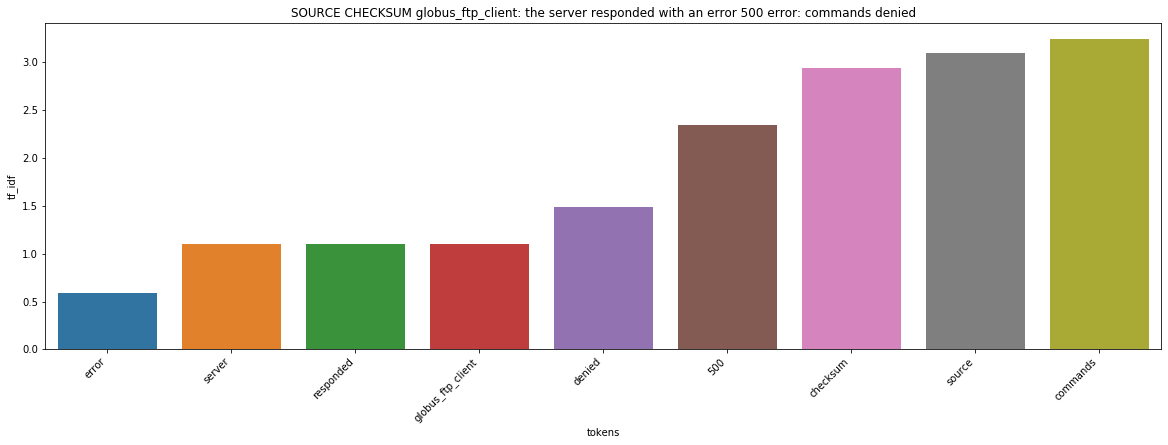

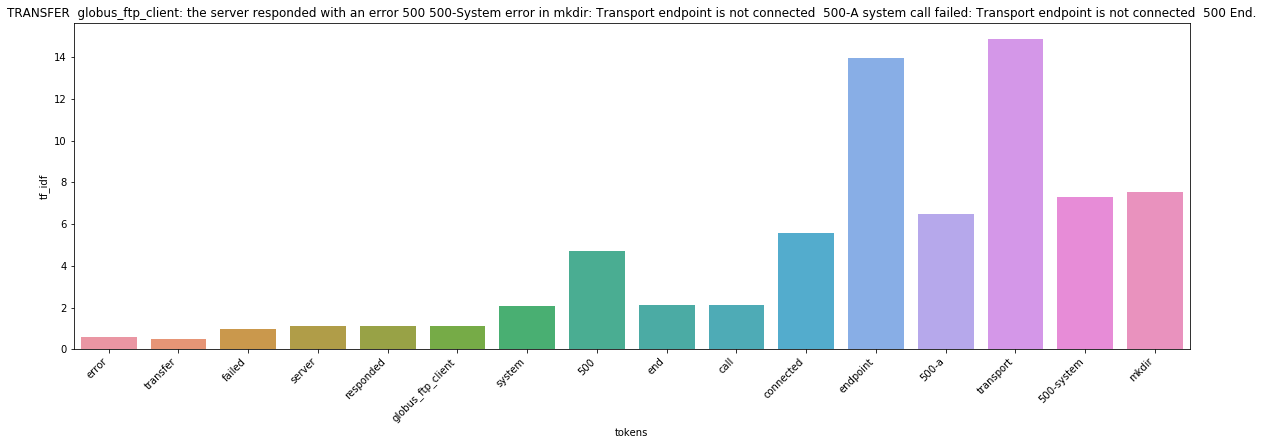

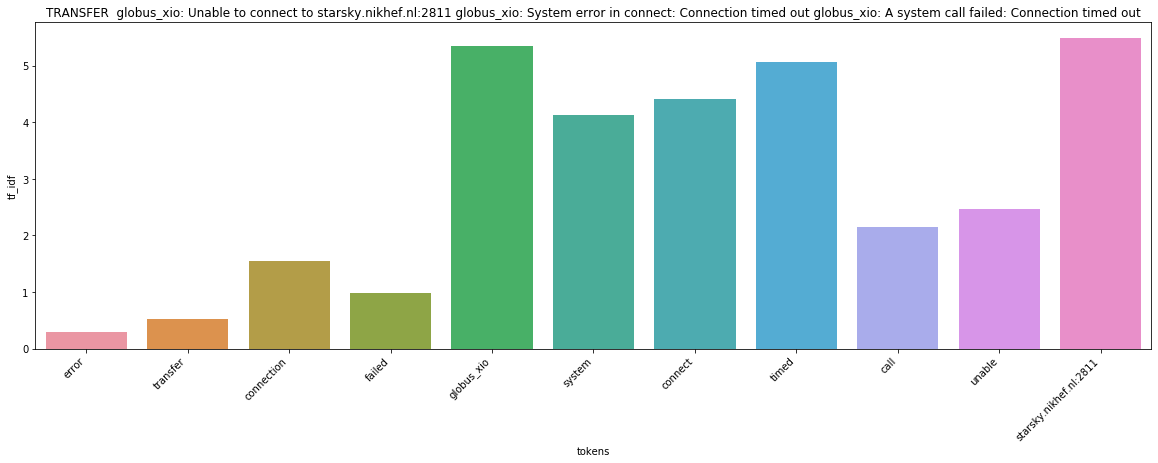

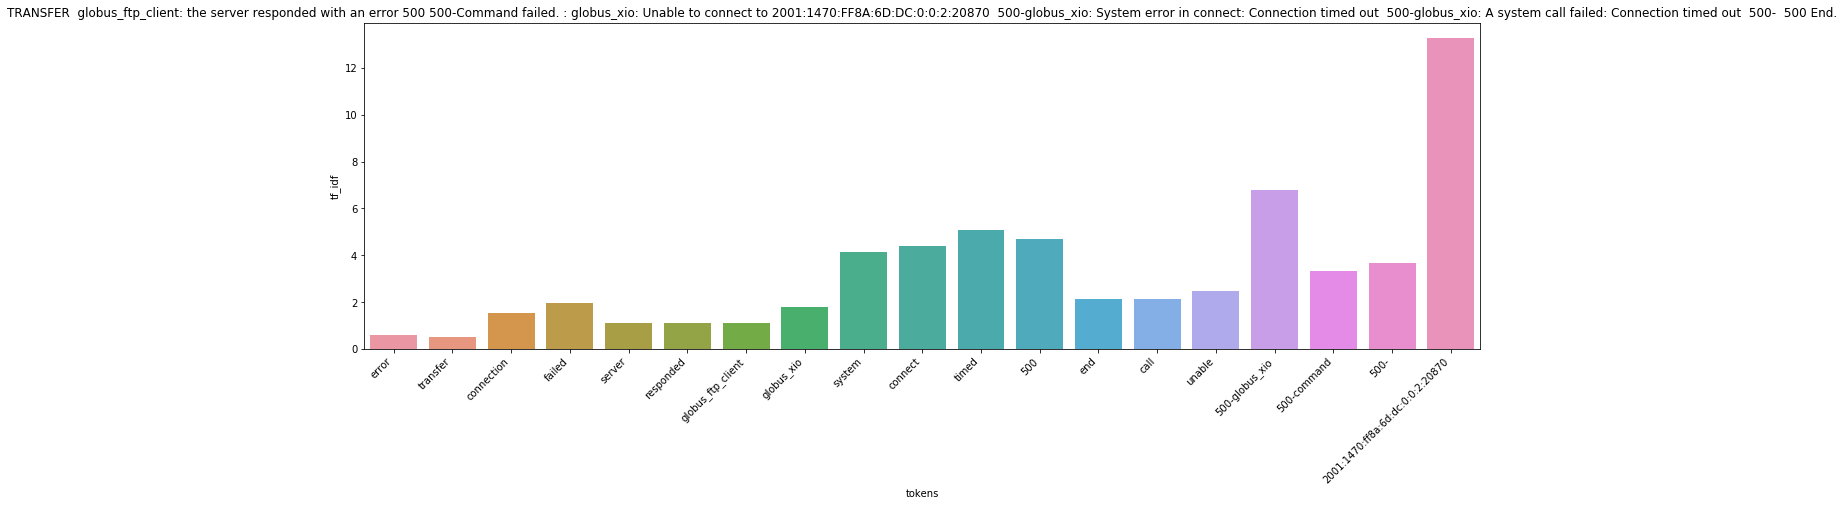

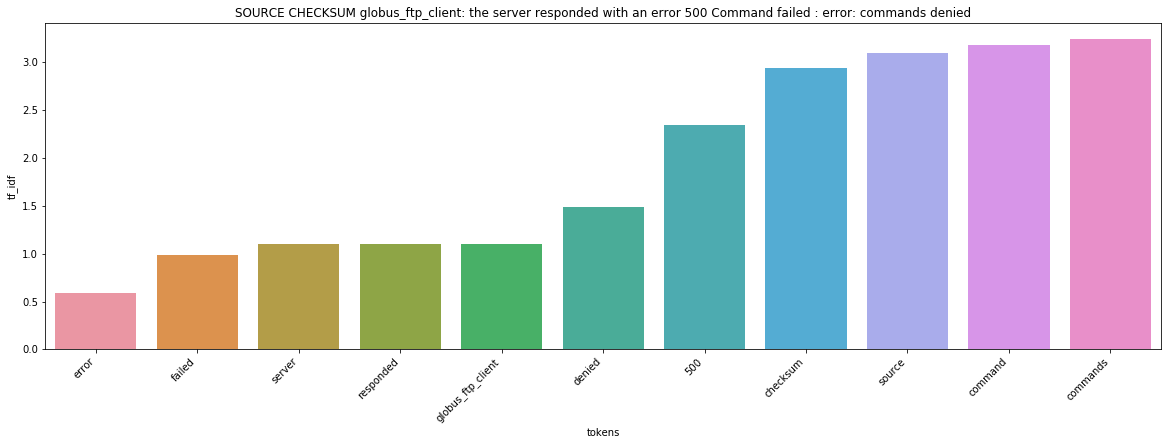

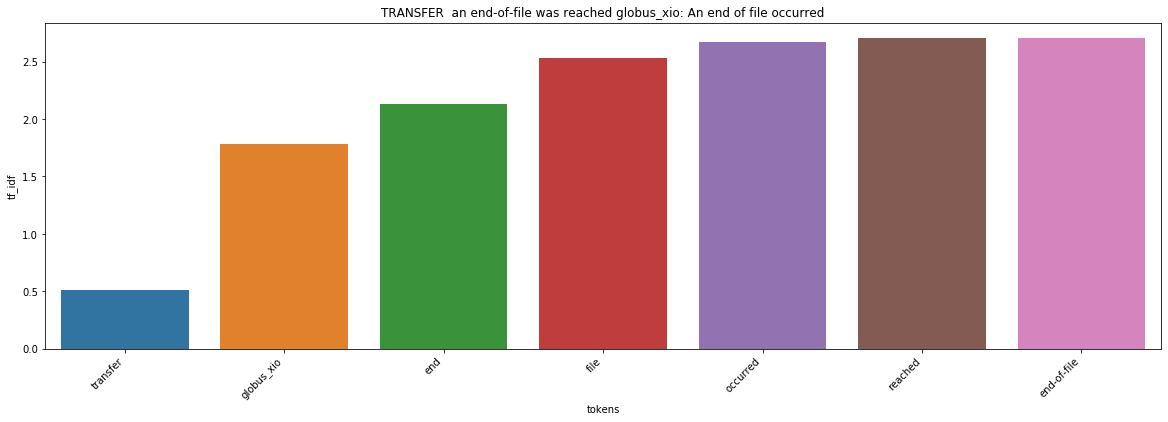

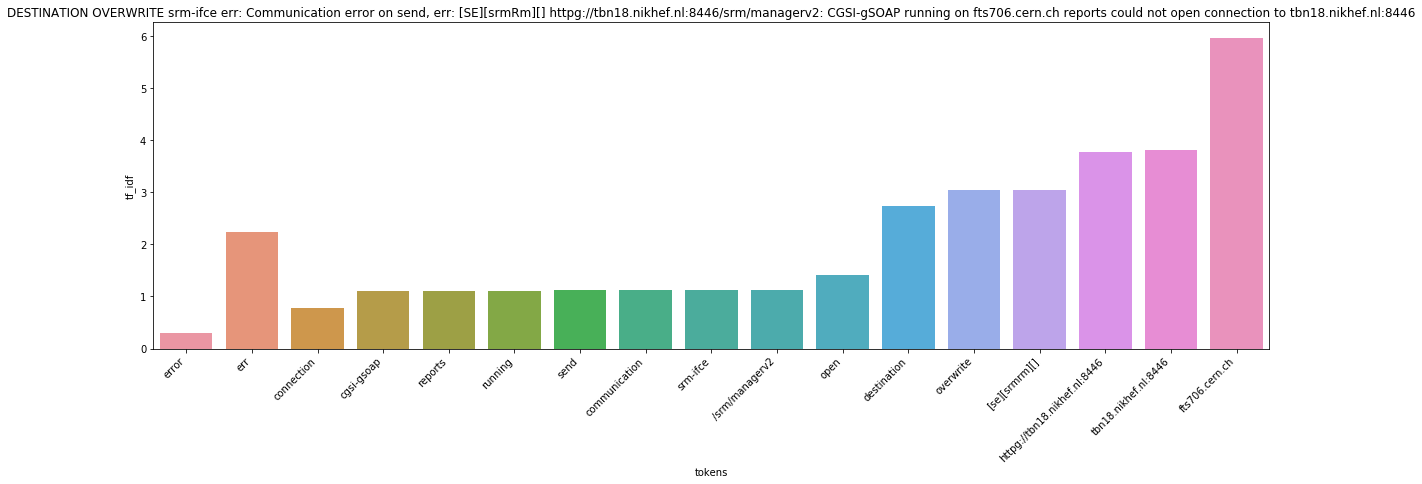

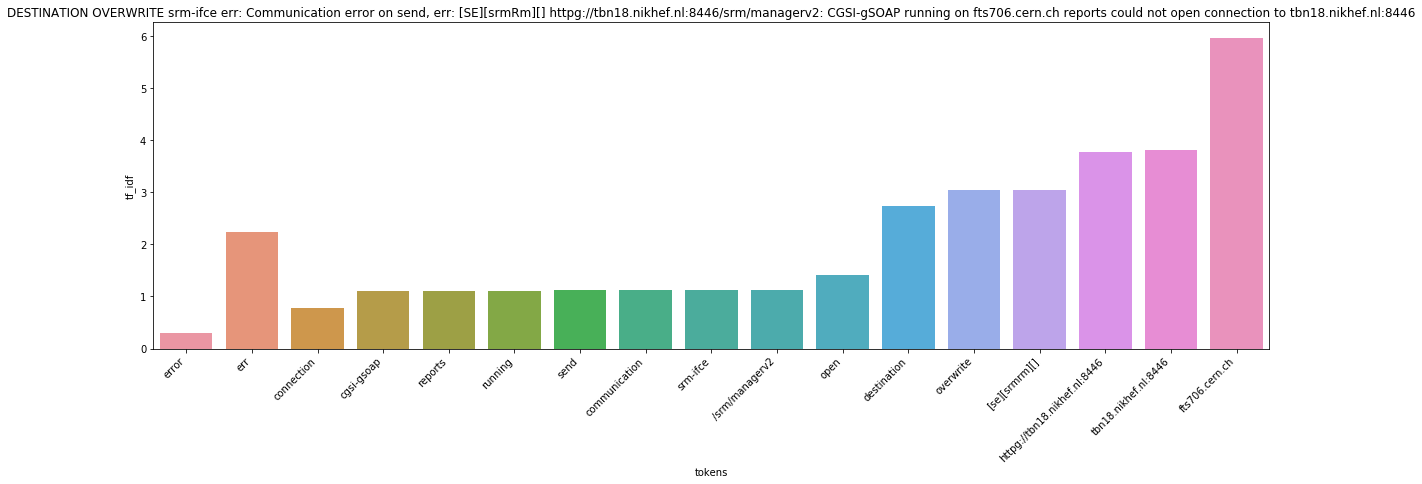

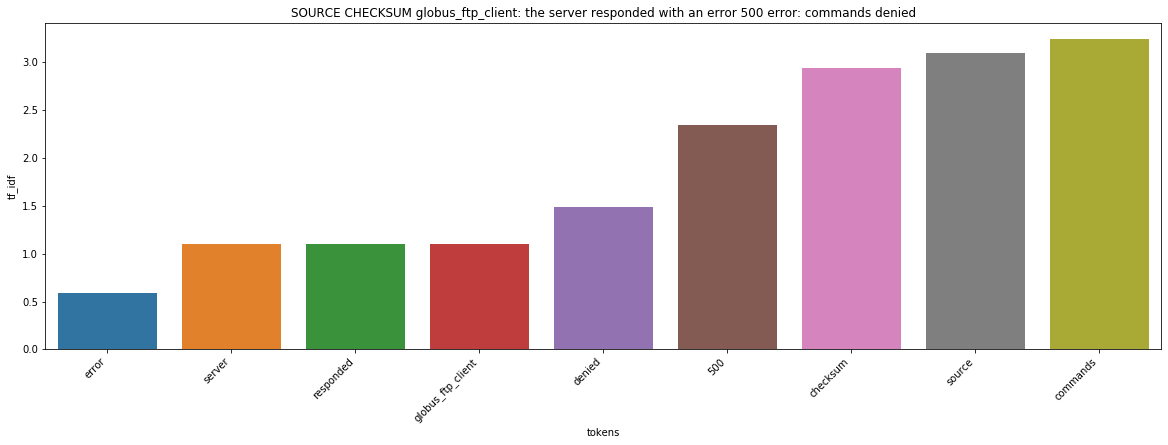

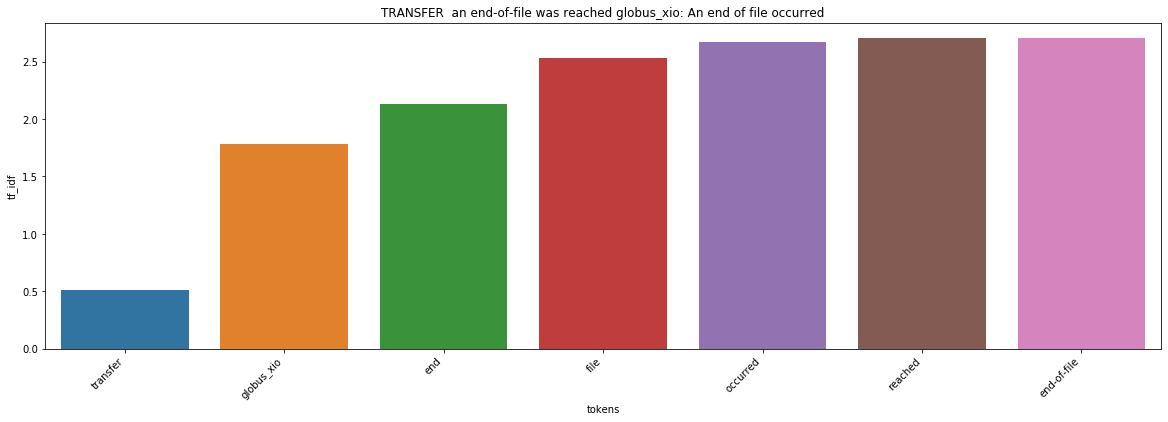

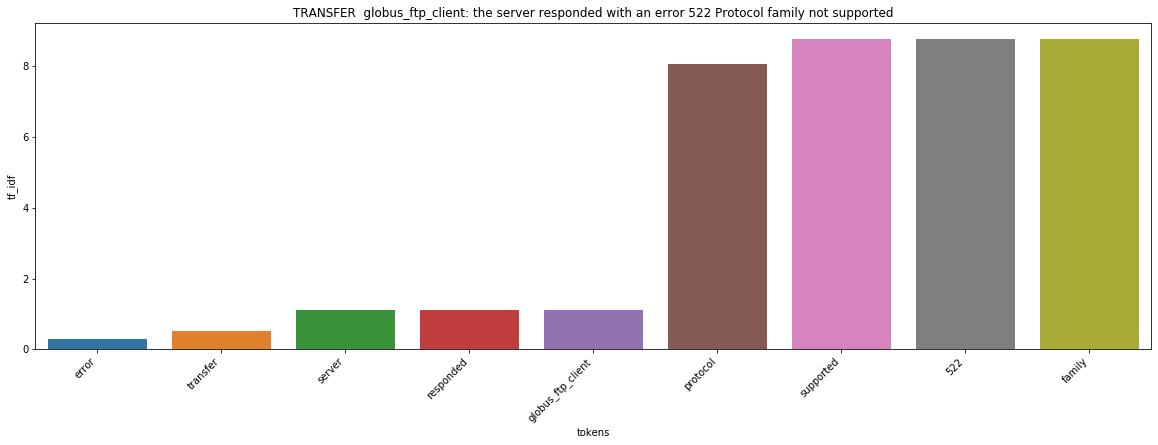

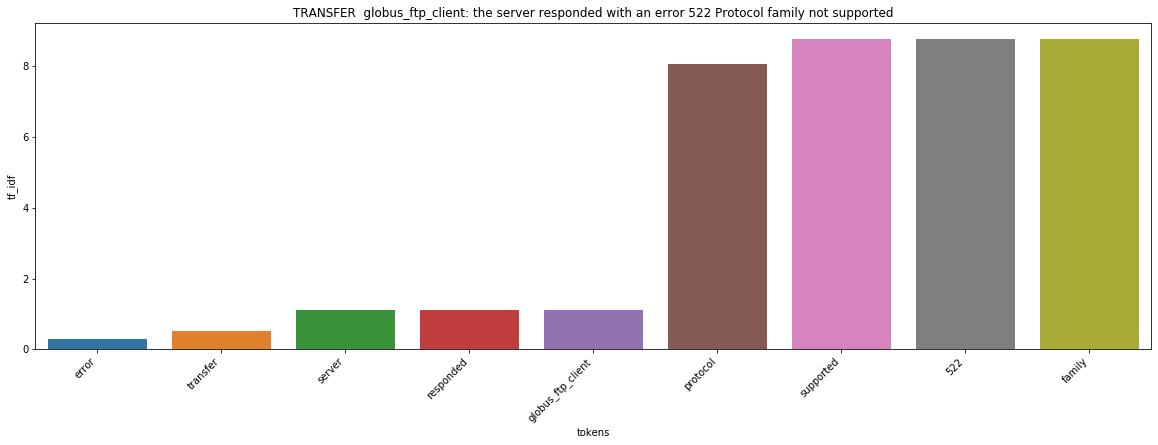

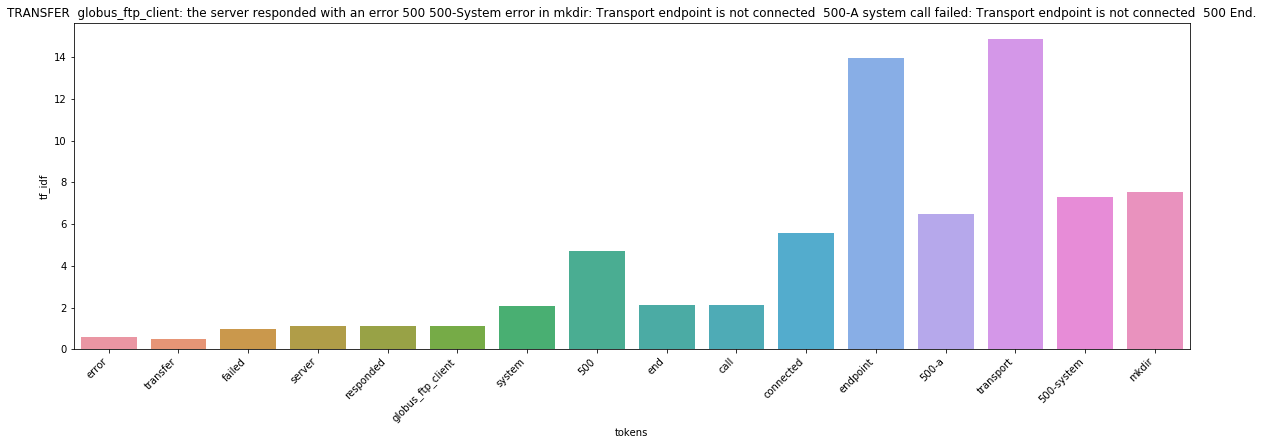

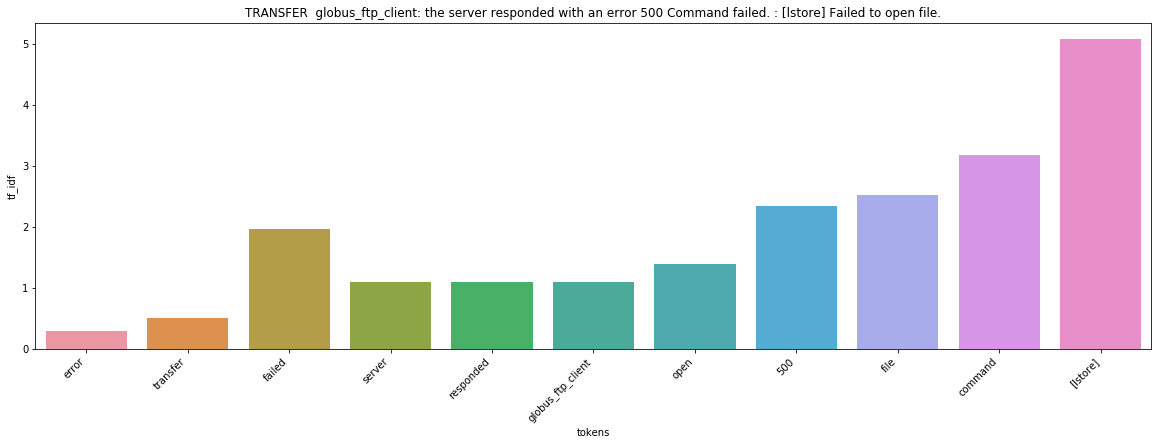

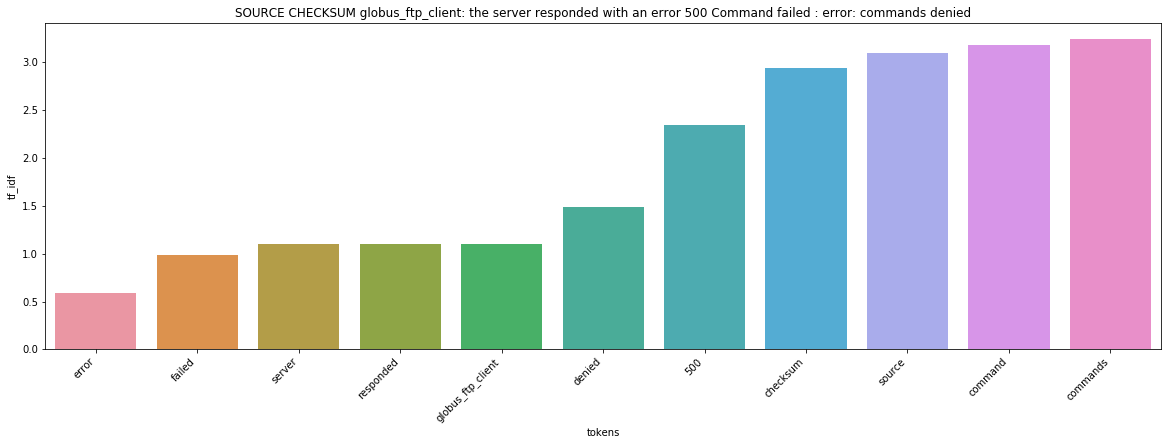

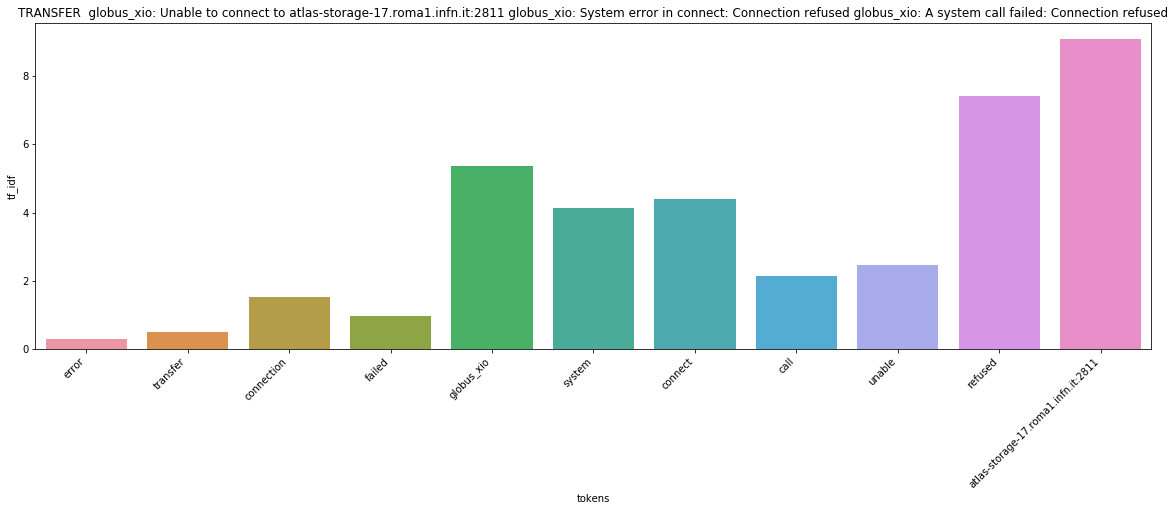

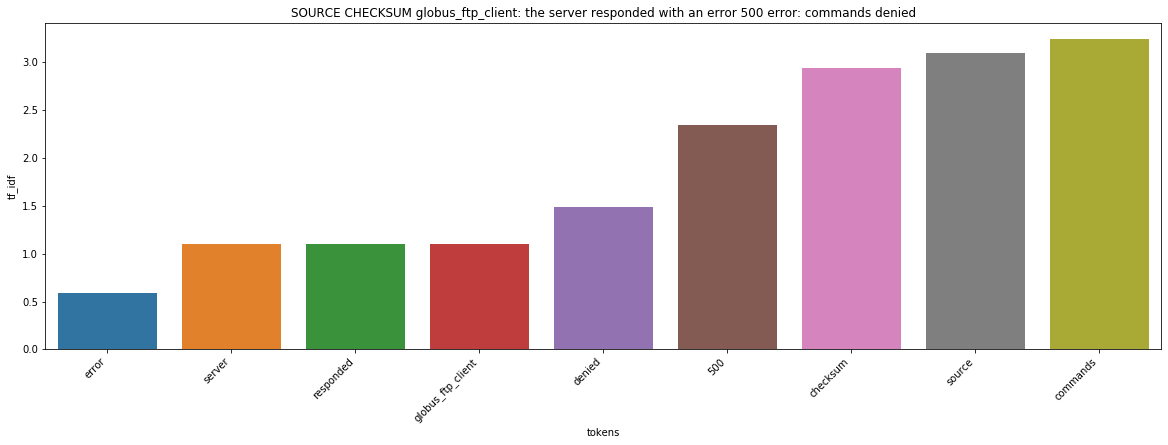

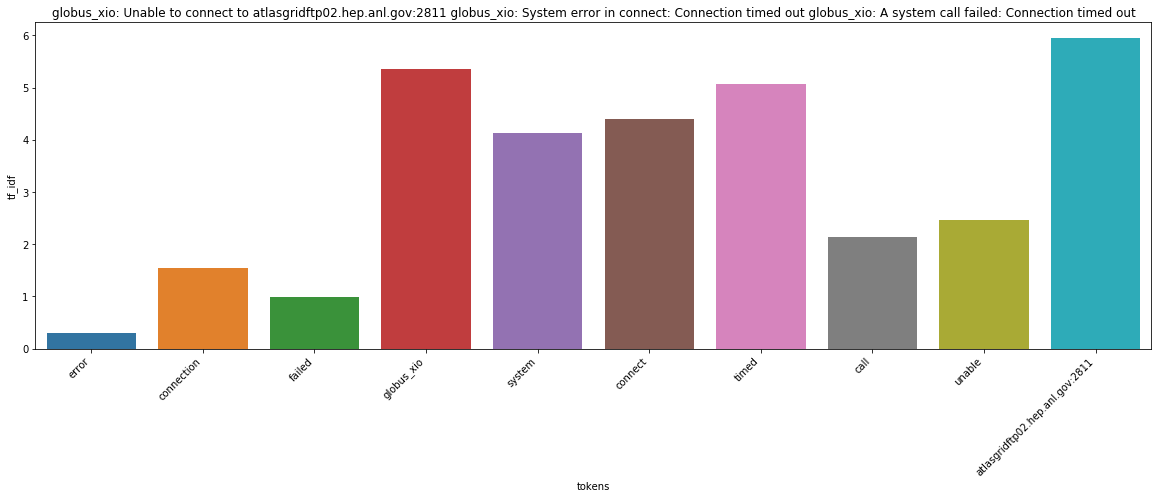

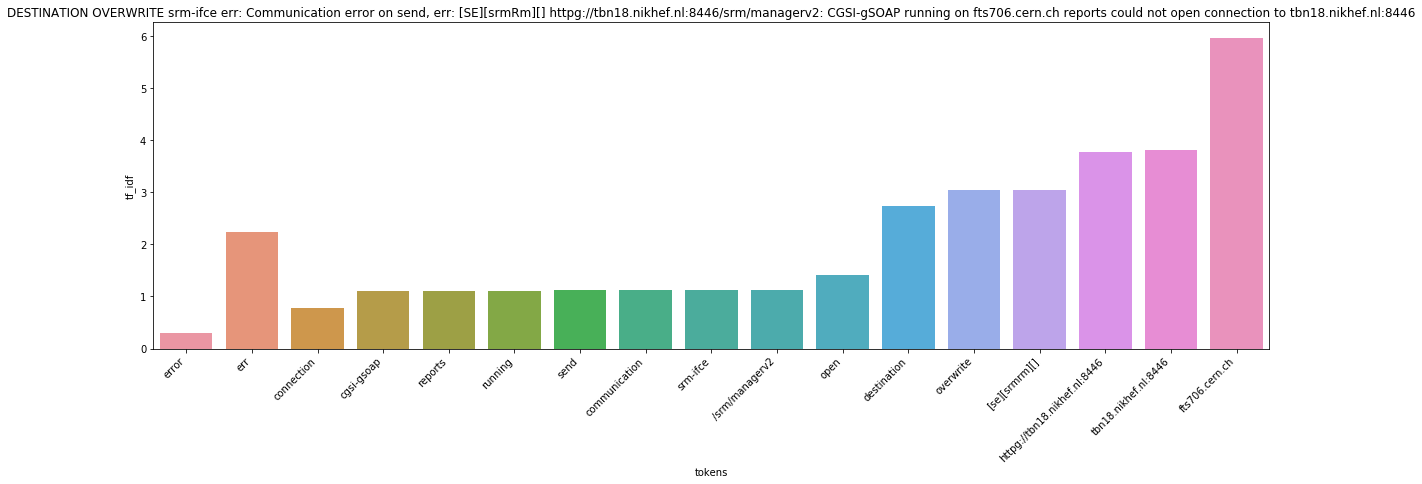

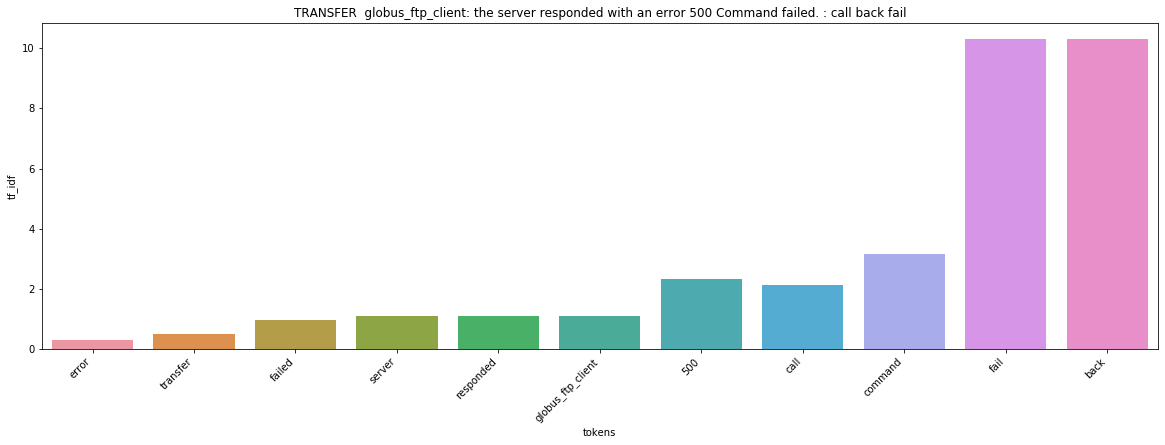

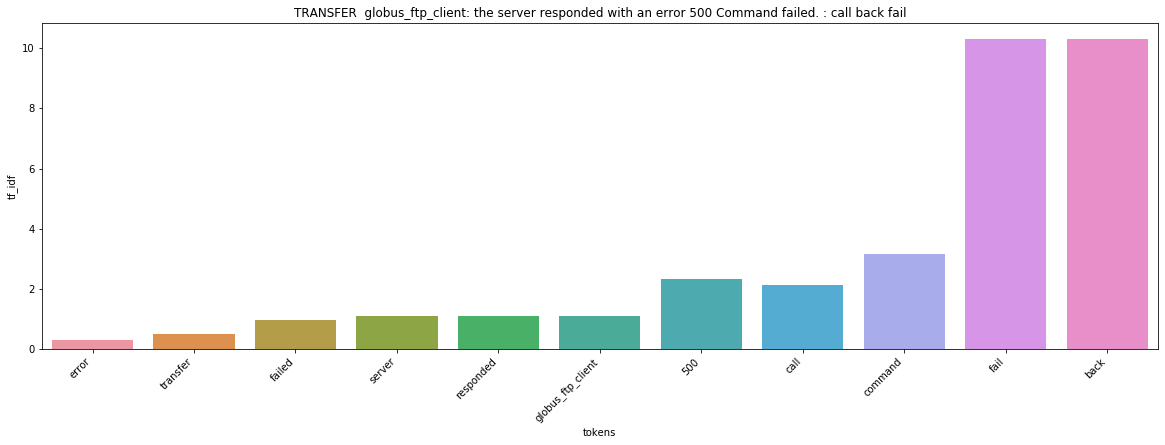

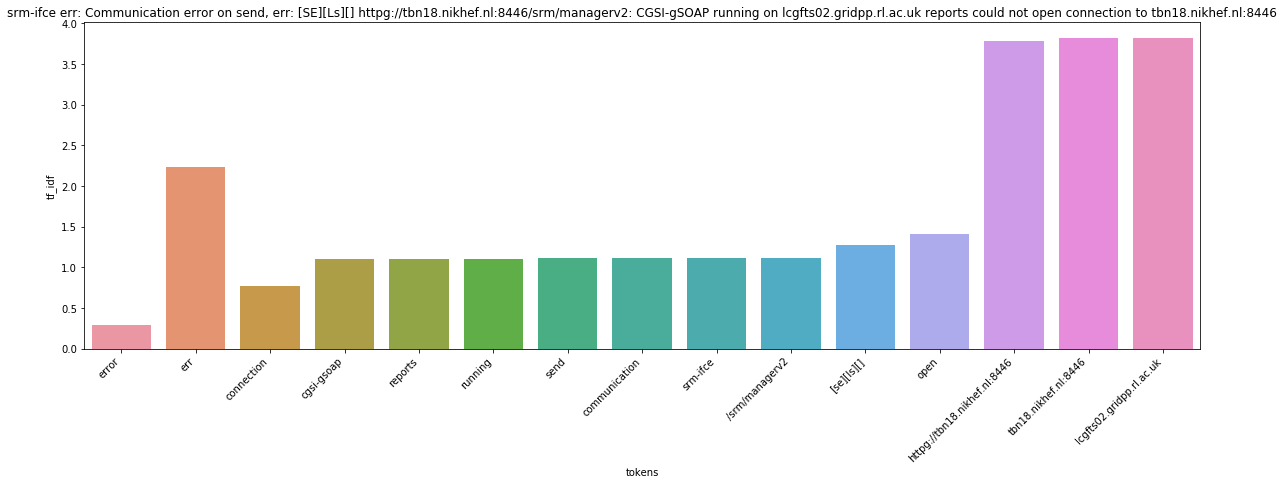

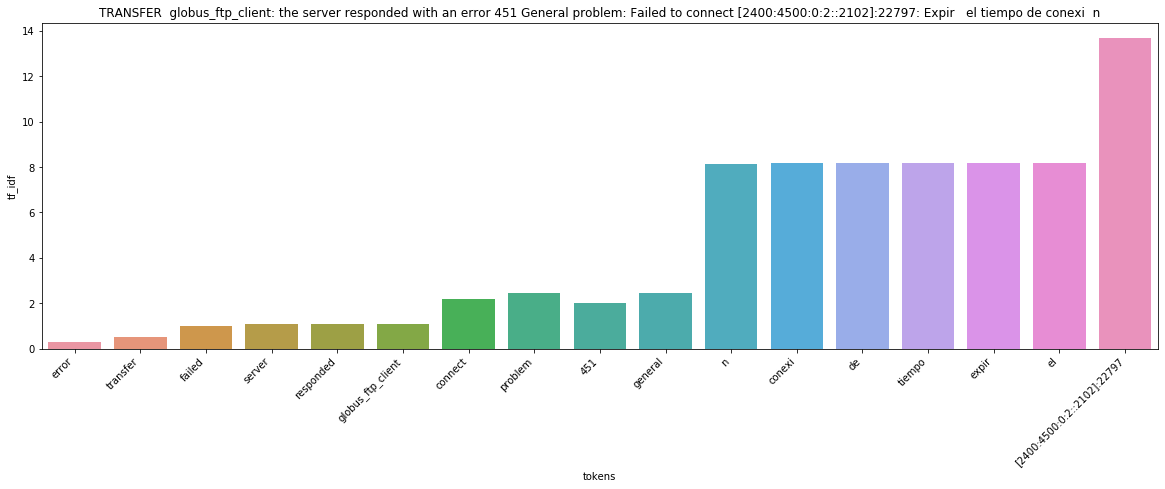

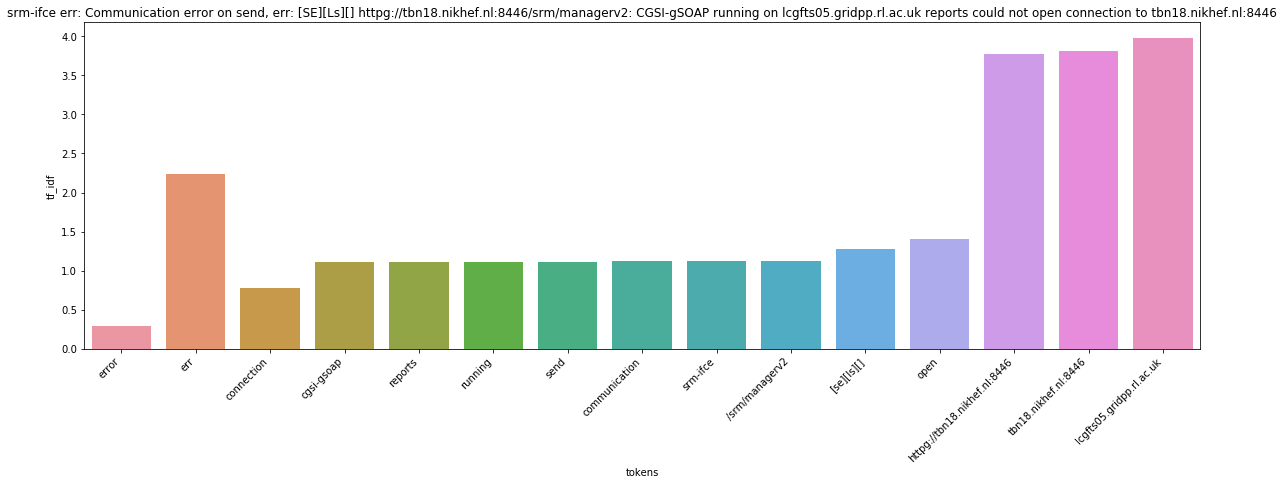

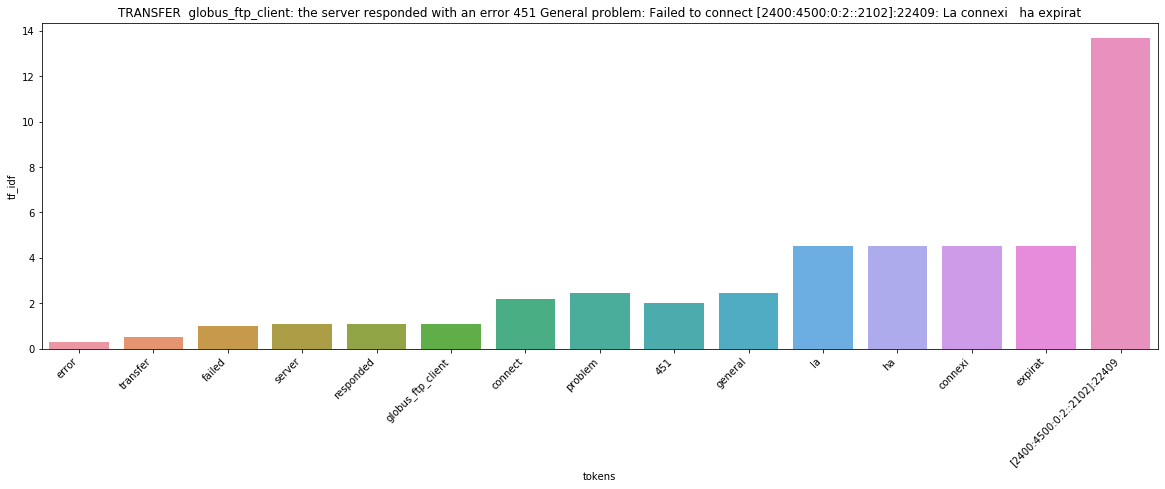

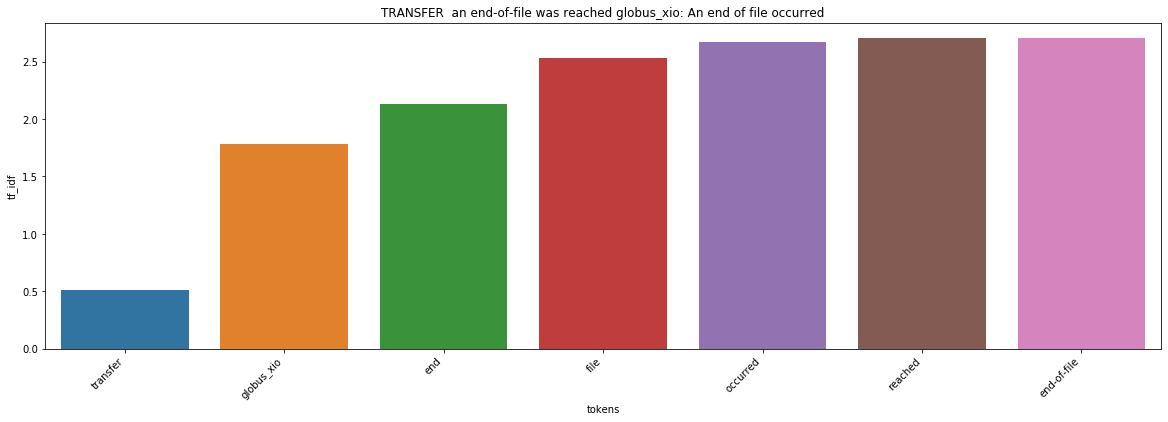

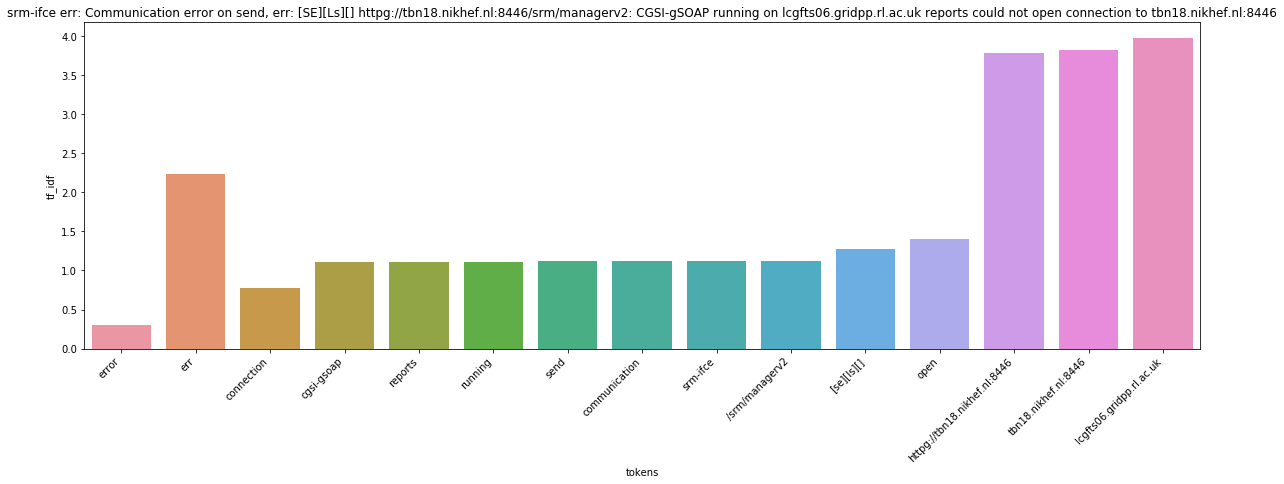

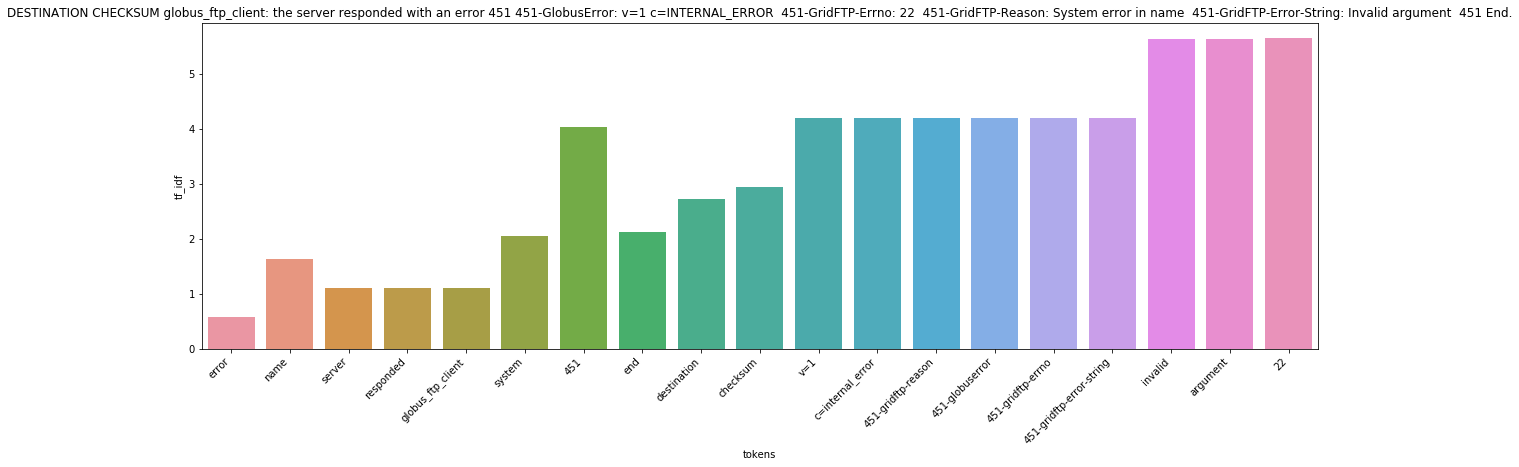

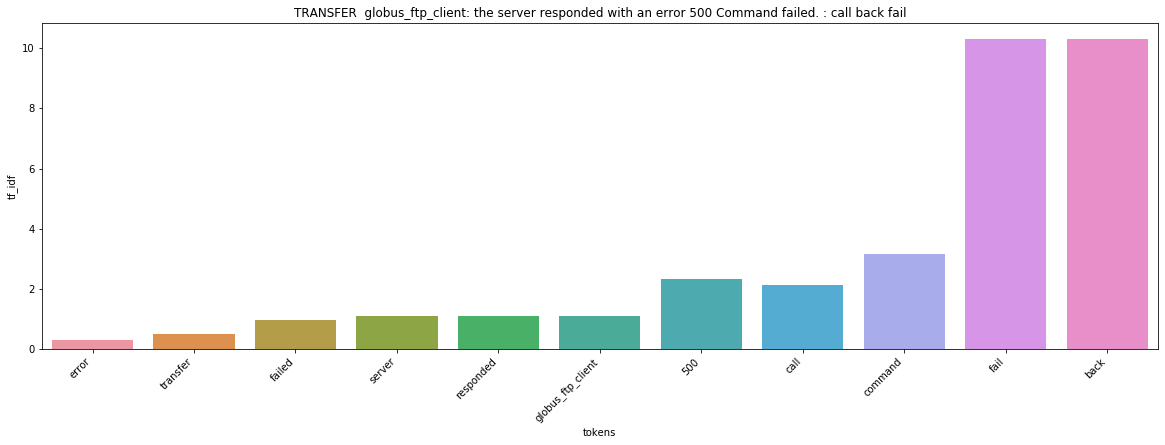

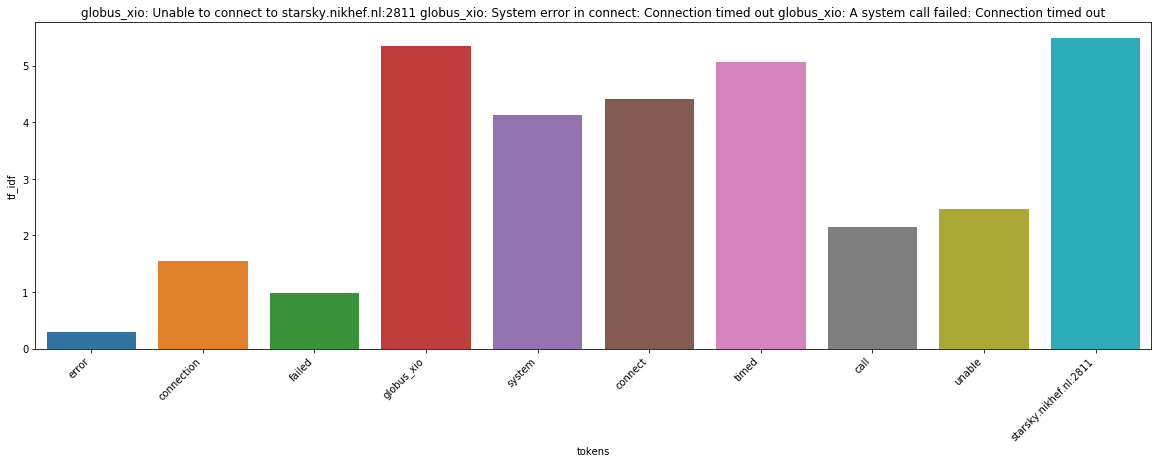

In [51]:
import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt



for i, row in enumerate(vector_data.limit(30).select("stop_token_1_cleaned","tf_idf", "t__error_message").collect()):
    
    # extract data
    y = row[1]
    x = [vectorizers[0].vocabulary[x] for x in y.indices]#row[0]#.split()
    data = pd.DataFrame({"tokens": x,"tf_idf": y.values})

    fig, ax = plt.subplots(figsize=(20,6))
    plt.title(row[2])
    g = sns.barplot(ax=ax, x="tokens", y="tf_idf", data=data)
    g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right')
    plt.show()

```list(set(vocab_nodash) - set(vocab_dash))```

['451-gridftp-reason',
 '500-internal',
 '500-globus_common',
 '451-gridftp-errno',
 '500-an',
 '500-globus_xio',
 '451-globuserror',
 '500-gridftp-reason',
 '500-globus_xio_system_select.c:globus_l_xio_system_handle_write:1108',
 '500-a',
 '500-system',
 '500-globuserror',
 '500-unable',
 '500-handle',
 '451-gridftp-error-stri',
 '500-command',
 '451-gridftp-error-string',
 '500-gridftp-error-string',
 '500-gridftp-errno']
 
 ```list(set(vocab_dash) - set(vocab_nodash))```

['an',
 'globus_xio_system_select.c:globus_l_xio_system_handle_write:1108',
 'gridftp-errno',
 'a',
 'gridftp-error-string',
 'gridftp-error-stri',
 'gridftp-reason']

In [133]:
len(vocab_dash), len(vocab_nodash)

(160764, 160776)

In [146]:
import pyspark.sql.functions as F

a = vector_data.where(F.array_contains("stop_token_1_cleaned", "20789"))
a.cache()
a.select("t__error_message").show(truncate=False)
# vector_data.withColumn("new", F.when("23535" in F.col("stop_token_1_cleaned"))).filter("new").select("stop_token_1_cleaned")

+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|t__error_message                                                                                                                                                                                                                                                                                                                                                                                                                                                             

In [134]:
vocab_dash

['error',
 'err',
 'transfer',
 'connection',
 'name',
 'failed',
 'globus_xio',
 'remote',
 'entity',
 'server',
 'responded',
 'globus_ftp_client',
 'cgsi-gsoap',
 'reports',
 'running',
 'send',
 'communication',
 'srm-ifce',
 '/srm/managerv2',
 '[se][ls][]',
 '500',
 'open',
 'system',
 'denied',
 'service',
 '451',
 'connect',
 'gss',
 'status',
 'globus_gsi_gssapi',
 'major',
 'unexpected',
 'globus_ftp_control',
 'expected',
 'gatekeeper',
 'gss_init_sec_context',
 'match',
 'authorization',
 '(/cn=dtn.ilifu.ac.za)',
 '(/dc=eu/dc=egi/c=za/o=hosts/o=university',
 'town/cn=dtn.ilifu.ac.za)',
 'cape',
 'problem',
 'timed',
 'end',
 'call',
 'reading',
 'token',
 'data',
 'header',
 'general',
 'unable',
 'file',
 'command',
 'occurred',
 'reached',
 'end-of-file',
 'destination',
 'closed',
 'connected',
 'closedchannelexception',
 'checksum',
 'refused',
 'internal',
 'overwrite',
 '[se][srmrm][]',
 'source',
 'space',
 'lcgfts01.gridpp.rl.ac.uk',
 'peer',
 'reset',
 '431',
 'comm

#### Word2Vec 

In [11]:
# subsample data
sub1 = vector_data.sample(withReplacement=False, fraction=0.3, seed=4)

In [12]:
from pyspark.ml.feature import Word2Vec

In [ ]:
%%time

# intialise word2vec
word2vec = Word2Vec(vectorSize = 200, minCount = 1, inputCol = 'stop_token_1_cleaned', outputCol = 'message_vector')

# for i in range(550000, 900000, 50000):
#     # fit the model
#     print(i)
#     train_data = vector_data.select("stop_token").limit(i)
#     model = word2vec.fit(train_data)

train_data = sub1.select("stop_token_1_cleaned")#.limit(500000)
# train_data = vector_data.select("stop_token").limit(500000)
model = word2vec.fit(train_data)

In [ ]:
# model.save("word2vec_trial_500000") # first attempt
# model.save("word2vec_trial_500000_2") # second attempt
# model.save("word2vec_trial_random_sample") # ~513k rows
model.save("word2vec_trial_random_sample_cleaned-tks") # ~513k rows

<div class="alert alert-block alert-info">
    <b>Note:</b> I should probably scale the stop_words column before feeding it into word2vec model.
</div>

## Custering 

In [15]:
# load back the word2vec model
from pyspark.ml.feature import Word2VecModel
w2vec_model = Word2VecModel.load('word2vec_trial_random_sample')

# apply it to the data to obtain the embedded representation
train_data = sub1.select("t__error_message", "stop_token_1")#.limit(500000)
train_data = w2vec_model.transform(train_data)

In [16]:
# from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

In [17]:
vec_assembler = VectorAssembler(inputCols = ["message_vector"], outputCol='features')

In [18]:
# format data to feed it into pyspark ML models
train_data = vec_assembler.transform(train_data)

In [ ]:
# from pyspark.ml.feature import StandardScaler
# scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=False)

# # Compute summary statistics by fitting the StandardScaler
# scalerModel = scaler.fit(final_data)

# # Normalize each feature to have unit standard deviation.
# cluster_final_data = scalerModel.transform(final_data)

### K-Means 

In [19]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

In [ ]:
# kmeans3 = KMeans(featuresCol='scaledFeatures',k=3)
# kmeans2 = KMeans(featuresCol='scaledFeatures',k=2)
# model_k3 = kmeans3.fit(cluster_final_data)
# model_k2 = kmeans2.fit(cluster_final_data)

In [19]:
%%time

for k in [4, 8, 12]:
    kmeans = KMeans(featuresCol='features',k=k)
    clustering_model = kmeans.fit(train_data)
    wsse = clustering_model.computeCost(train_data)
    print("With K={}".format(k))
    print("Within Cluster Sum of Squared Errors = " + str(wsse))
    print('--'*30)

With K=4
Within Cluster Sum of Squared Errors = 1105823.215118624
------------------------------------------------------------
With K=8
Within Cluster Sum of Squared Errors = 574994.4382240158
------------------------------------------------------------
With K=12
Within Cluster Sum of Squared Errors = 190451.01787681086
------------------------------------------------------------
CPU times: user 2.2 s, sys: 763 ms, total: 2.96 s
Wall time: 36min 1s


In [119]:
%%time

# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator()

kmeans_models = []
clustering_model = []

for i, k in enumerate([4, 8, 12]):
    kmeans_models.append(KMeans(featuresCol='features',k=k, initMode='k-means||',
    initSteps=3, tol=0.0001, maxIter=30, distanceMeasure='euclidean'))
    clustering_model.append(kmeans_models[i].fit(train_data))
    
    # compute metrics   
    wsse = clustering_model[i].summary.trainingCost
    silhouette = evaluator.evaluate(clustering_model[i].summary.predictions)

    print("With K={}".format(k))
    print("Within Cluster Sum of Squared Errors = " + str(wsse))
    print("Silhouette with squared euclidean distance = " + str(silhouette))
    print('--'*30)

With K=4
Within Cluster Sum of Squared Errors = 727031.1633097911
Silhouette with squared euclidean distance = 0.6881141727297889
------------------------------------------------------------
With K=8
Within Cluster Sum of Squared Errors = 411007.03987435
Silhouette with squared euclidean distance = 0.6675920768710636
------------------------------------------------------------
With K=12
Within Cluster Sum of Squared Errors = 204043.00025558987
Silhouette with squared euclidean distance = 0.7813034198788781
------------------------------------------------------------
CPU times: user 2.37 s, sys: 732 ms, total: 3.1 s
Wall time: 38min 46s


##### Saving clustering models 

In [35]:
for i, model in enumerate(kmeans_models):
    model.save("kmeans_k{}".format([4, 8, 12][i]))

In [124]:
for i, model in enumerate(clustering_model):
    model.write().overwrite().save("kmeans_k{}_trained".format(model.summary.k))

#### Posterior checks 

In [113]:
from pyspark.ml.clustering import KMeansModel

clustering_model = []
for k in [4,8,12]:
    clustering_model.append(KMeansModel.load("kmeans_k{}_trained".format(k)))

In [133]:
import numpy as np

for model in clustering_model:
    print("\n\nkmeans: K = {}".format(model.summary.k))
    print("Maximum number of iterations: {}".format(model.summary.numIter))
    
    # sort cluster sizes
    ord_sizes = model.summary.clusterSizes
    ord_idx = list(np.argsort(model.summary.clusterSizes))
    ord_sizes.sort(reverse=True)
    ord_idx.reverse()
    print("Cluster sizes:")
    for el in zip(ord_idx, ord_sizes):
        print("{}".format(el))



kmeans: K = 4
Maximum number of iterations: 3
Cluster sizes:
(1, 173824)
(0, 162717)
(2, 97342)
(3, 87072)


kmeans: K = 8
Maximum number of iterations: 7
Cluster sizes:
(2, 125602)
(4, 104501)
(1, 97342)
(0, 52267)
(6, 48034)
(3, 43361)
(5, 34609)
(7, 15239)


kmeans: K = 12
Maximum number of iterations: 8
Cluster sizes:
(10, 125293)
(1, 97342)
(7, 50822)
(3, 48032)
(4, 46244)
(0, 39916)
(5, 34609)
(9, 34224)
(2, 20523)
(6, 11969)
(11, 10766)
(8, 1215)


In [141]:
import pyspark.sql.functions as F

for model in clustering_model:
    grouped_pred = model.summary.predictions.groupBy("prediction")
    grouped_pred.agg(F.countDistinct("stop_token_1").alias("n_unique_mess")).orderBy("n_unique_mess", ascending=False).show(truncate=False)

+----------+-------------+
|prediction|n_unique_mess|
+----------+-------------+
|0         |45253        |
|3         |10698        |
|1         |3375         |
|2         |17           |
+----------+-------------+

+----------+-------------+
|prediction|n_unique_mess|
+----------+-------------+
|4         |45231        |
|0         |10633        |
|6         |1839         |
|2         |1386         |
|7         |223          |
|1         |17           |
|3         |10           |
|5         |4            |
+----------+-------------+

+----------+-------------+
|prediction|n_unique_mess|
+----------+-------------+
|4         |37947        |
|9         |17660        |
|3         |1838         |
|10        |1383         |
|0         |234          |
|7         |114          |
|8         |95           |
|2         |43           |
|1         |17           |
|6         |7            |
|5         |4            |
|11        |1            |
+----------+-------------+



In [198]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

def is_url(string):
    if string.find("://") != -1:
        return(True)
    return(False)
    

def is_ipv6(string):
    import numpy as np
    is_column = [1 if x==":" else 0 for x in string]
    if np.sum(is_column) >= 3 and string.find("/") == -1:
        return(True)
    return(False)

def is_address(string):
    import numpy as np
    is_column = [1 if x=="." else 0 for x in string]
    if np.sum(is_column) >= 2 and string.find("/") == -1:
        return(True)
    return(False)

def replace_address(string, replace_string=None):
    if not replace_string:
        if is_url(string):
            string = "$URL"
        elif is_ipv6(string):
            string = "$IPv6"
        elif is_address(string):
            string = "$ADDRESS"
    else:
        if is_url(string) or is_ipv6(string) or is_address(string):
            string = replace_string         
    return(string)


def abstract_address(tokens_list):
    '''Take a string and split url into netloc + path'''
    tks = [replace_address(x) for x in tokens_list]
    return(tks)

# transform in user defined function
abstract_address_udf = udf(abstract_address, StringType())

In [200]:
import pyspark.sql.functions as F

for model in clustering_model:
    data_subset = model.summary.predictions
    data_subset = data_subset.withColumn("abstract_tokens", abstract_address_udf("stop_token_1"))

    grouped_pred = data_subset.groupBy("prediction")
    grouped_pred.agg(F.countDistinct("abstract_tokens").alias("n_unique_mess")).orderBy("n_unique_mess", ascending=False).show(truncate=False)

+----------+-------------+
|prediction|n_unique_mess|
+----------+-------------+
|0         |6594         |
|1         |157          |
|3         |86           |
|2         |17           |
+----------+-------------+

+----------+-------------+
|prediction|n_unique_mess|
+----------+-------------+
|4         |6525         |
|7         |181          |
|0         |65           |
|6         |29           |
|2         |25           |
|1         |17           |
|3         |10           |
|5         |4            |
+----------+-------------+

+----------+-------------+
|prediction|n_unique_mess|
+----------+-------------+
|9         |6584         |
|7         |114          |
|4         |42           |
|3         |28           |
|0         |26           |
|10        |22           |
|1         |17           |
|6         |7            |
|8         |5            |
|5         |4            |
|2         |4            |
|11        |1            |
+----------+-------------+



In [179]:
print(is_url("httpg://tbn18.nikhef.nl:8446/srm/managerv2:"))
print(is_url("2400:4500:0:2::2102:22409:"))
print(is_url("tbn18.nikhef.nl:8446"))

True
False
False


In [180]:
print(is_ipv6("httpg://tbn18.nikhef.nl:8446/srm/managerv2:"))
print(is_ipv6("2400:4500:0:2::2102:22409:"))
print(is_ipv6("tbn18.nikhef.nl:8446"))

False
True
False


In [183]:
print(is_address("httpg://tbn18.nikhef.nl:8446/srm/managerv2:"))
print(is_address("2400:4500:0:2::2102:22409:"))
print(is_address("tbn18.nikhef.nl:8446"))

False
False
True


In [194]:
print(replace_address("httpg://tbn18.nikhef.nl:8446/srm/managerv2:"))
print(replace_address("2400:4500:0:2::2102:22409:"))
print(replace_address("tbn18.nikhef.nl:8446"))
print(replace_address("ERROR"))
print(replace_address("tbn18.nikhef.nl:8446", "CIAO"))

$URL
$IPv6
$ADDRESS
ERROR
CIAO


#### Inspection (K=12)

In [204]:
clust_ids = ["1", "6", "8", "5", "2", "11"]

data_subset = clustering_model[2].summary.predictions.withColumn("abstract_tokens", abstract_address_udf("stop_token_1"))


for clust_id in clust_ids:
    cluster = data_subset.filter("prediction == {}".format(clust_id))
    
    cluster_unique_messages = cluster.select("abstract_tokens").distinct()
    cluster_unique_messages.show(truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|abstract_tokens                                                                                                                                                                                                                                                                                                                                                                                          |
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|abstract_tokens                                                                                                                                                             |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|[transfer, globus_ftp_client:, server, responded, error, 421, service, busy:, connection, limit, exceeded., please, try, later., closing, control, connection.]             |
|[globus_ftp_client:, server, responded, error, 421, idle, timeout:, closing, control, connection.]                                                                          |
|[globus_ftp_client:, server, responded, error, 421, service, busy:, connection, limit, exceeded., please, try, later., closi

In [144]:
clust_id = "11"

data_subset = clustering_model[2].summary.predictions
cluster = data_subset.filter("prediction == {}".format(clust_id))

cluster_unique_messages = cluster.select("stop_token_1").distinct()
cluster_unique_messages.show(truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------+
|stop_token_1                                                                                                                                       |
+---------------------------------------------------------------------------------------------------------------------------------------------------+
|[transfer, globus_ftp_client:, server, responded, error, 451, diskcachev111.services.space.nofreespaceexception:, space, id=2310037, enough, space]|
+---------------------------------------------------------------------------------------------------------------------------------------------------+



In [145]:
clust_id = "2"

data_subset = clustering_model[2].summary.predictions
cluster = data_subset.filter("prediction == {}".format(clust_id))

cluster_unique_messages = cluster.select("stop_token_1").distinct()
cluster_unique_messages.show(truncate=False)

+-----------------------------------------------------------------------------------------------------------------------------------+
|stop_token_1                                                                                                                       |
+-----------------------------------------------------------------------------------------------------------------------------------+
|[transfer, globus_ftp_client:, server, responded, error, 555, srm, upload, aborted:, file, deleted, request, 1om:28788412:srm2:rm.]|
|[transfer, globus_ftp_client:, server, responded, error, 555, srm, upload, aborted:, file, deleted, request, hru:7380954:srm2:rm.] |
|[transfer, globus_ftp_client:, server, responded, error, 555, srm, upload, aborted:, file, deleted, request, hru:7381160:srm2:rm.] |
|[transfer, globus_ftp_client:, server, responded, error, 555, srm, upload, aborted:, file, deleted, request, hru:5863600:srm2:rm.] |
|[transfer, globus_ftp_client:, server, responded, error, 555,

## RANDOM TRIALS 

### Example for meeting: K=12, distance="cosine"

In [20]:
%%time

# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator()

kmeans_models = []
clustering_model = []

for i, k in enumerate([12]):
    kmeans_models.append(KMeans(featuresCol='features',k=k, initMode='k-means||',
    initSteps=3, tol=0.0001, maxIter=30, distanceMeasure='cosine'))
    clustering_model.append(kmeans_models[i].fit(train_data))
    
    # compute metrics   
    wsse = clustering_model[i].summary.trainingCost
    silhouette = evaluator.evaluate(clustering_model[i].summary.predictions)

    print("With K={}".format(k))
    print("Within Cluster Sum of Squared Errors = " + str(wsse))
    print("Silhouette with squared euclidean distance = " + str(silhouette))
    print('--'*30)

With K=12
Within Cluster Sum of Squared Errors = 19958.5066160693
Silhouette with squared euclidean distance = 0.7636261554589616
------------------------------------------------------------
CPU times: user 1.21 s, sys: 397 ms, total: 1.61 s
Wall time: 20min 22s


#### Clusters' sizes

In [21]:
import numpy as np

for model in clustering_model:
    print("\n\nkmeans: K = {}".format(model.summary.k))
    print("Maximum number of iterations: {}".format(model.summary.numIter))
    
    # sort cluster sizes
    ord_sizes = model.summary.clusterSizes
    ord_idx = list(np.argsort(model.summary.clusterSizes))
    ord_sizes.sort(reverse=True)
    ord_idx.reverse()
    print("Cluster sizes:")
    for el in zip(ord_idx, ord_sizes):
        print("{}".format(el))



kmeans: K = 12
Maximum number of iterations: 3
Cluster sizes:
(1, 125293)
(5, 97342)
(7, 59567)
(10, 48034)
(2, 44799)
(0, 34659)
(11, 34226)
(6, 31413)
(4, 21847)
(3, 18271)
(9, 3034)
(8, 2470)


#### Clusters' unique messages

In [22]:
import pyspark.sql.functions as F

for model in clustering_model:
    grouped_pred = model.summary.predictions.groupBy("prediction")
    grouped_pred.agg(F.countDistinct("stop_token_1").alias("n_unique_mess")).orderBy("n_unique_mess", ascending=False).show(truncate=False)

+----------+-------------+
|prediction|n_unique_mess|
+----------+-------------+
|2         |37799        |
|7         |10706        |
|4         |5499         |
|10        |1839         |
|8         |1546         |
|1         |1383         |
|9         |322          |
|6         |199          |
|11        |22           |
|5         |17           |
|0         |8            |
|3         |3            |
+----------+-------------+



#### Clusters' unique messages after abstraction 

In [23]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

def is_url(string):
    if string.find("://") != -1:
        return(True)
    return(False)
    

def is_ipv6(string):
    import numpy as np
    is_column = [1 if x==":" else 0 for x in string]
    if np.sum(is_column) >= 3 and string.find("/") == -1:
        return(True)
    return(False)

def is_address(string):
    import numpy as np
    is_column = [1 if x=="." else 0 for x in string]
    if np.sum(is_column) >= 2 and string.find("/") == -1:
        return(True)
    return(False)

def replace_address(string, replace_string=None):
    if not replace_string:
        if is_url(string):
            string = "$URL"
        elif is_ipv6(string):
            string = "$IPv6"
        elif is_address(string):
            string = "$ADDRESS"
    else:
        if is_url(string) or is_ipv6(string) or is_address(string):
            string = replace_string         
    return(string)


def abstract_address(tokens_list):
    '''Take a string and split url into netloc + path'''
    tks = [replace_address(x) for x in tokens_list]
    return(tks)

# transform in user defined function
abstract_address_udf = udf(abstract_address, StringType())

In [24]:
import pyspark.sql.functions as F

for model in clustering_model:
    data_subset = model.summary.predictions
    data_subset = data_subset.withColumn("abstract_tokens", abstract_address_udf("stop_token_1"))

    grouped_pred = data_subset.groupBy("prediction")
    grouped_pred.agg(F.countDistinct("abstract_tokens").alias("n_unique_mess")).orderBy("n_unique_mess", ascending=False).show(truncate=False)

+----------+-------------+
|prediction|n_unique_mess|
+----------+-------------+
|4         |4784         |
|8         |1499         |
|6         |199          |
|9         |142          |
|7         |94           |
|2         |35           |
|10        |29           |
|11        |22           |
|1         |22           |
|5         |17           |
|0         |8            |
|3         |3            |
+----------+-------------+



In [26]:
clust_ids = ["3", "0", "1", "5", "10", "11"]

data_subset = clustering_model[0].summary.predictions.withColumn("abstract_tokens", abstract_address_udf("stop_token_1"))


for clust_id in clust_ids:
    cluster = data_subset.filter("prediction == {}".format(clust_id))
    
    cluster_unique_messages = cluster.select("abstract_tokens").distinct()
    cluster_unique_messages.show(truncate=False)

+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|abstract_tokens                                                                                                                                                                 |
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|[transfer, globus_ftp_client:, server, responded, error, 451, pools, full]                                                                                                      |
|[transfer, globus_ftp_client:, server, responded, error, 452, pools, full]                                                                                                      |
|[transfer, globus_ftp_client:, server, responded, error, 451, write, pools, online, [net=2001:1458:201:e

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|abstract_tokens                                                                                                                                                                                                                                                                                                                                                                                          |
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|abstract_tokens                                                                                                                                                                                                                     |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|[destination, overwrite, srm-ifce, err:, communication, error, send,, err:, [se][srmrm][], $URL, /srm/managerv2:, cgsi-gsoap, running, $ADDRESS, reports, error, reading, token, data, header:, connection, closed]                 |
|[error, reported, srm_ifce, 70, [se][ls][srm_internal_error], send2nsd:, ns

#### Small clusters 

##### Cluster 7 

In [26]:
clust_id = "7"
smaller_cluster = results.filter("prediction == {}".format(clust_id))

smaller_cluster_unique_messages = smaller_cluster.select("stop_token").distinct()
smaller_cluster_unique_messages.count()

5

In [27]:
smaller_cluster_unique_messages.show(truncate=False)

+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|stop_token                                                                                                                                                                                                                                                                         |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|[transfer, globus_ftp_client:, the, server, responded, with, an, error, 535, authentication, failed:, path, validation, failed:, path, validation, failed, for, cn=17

##### Cluster 5 

In [ ]:
clust_id = "5"
smaller_cluster = results.filter("prediction == {}".format(clust_id))

smaller_cluster_unique_messages = smaller_cluster.select("stop_token").distinct()
smaller_cluster_unique_messages.count()

In [34]:
smaller_cluster_unique_messages.show(truncate=False)

+------------------------------------------------------------------------------------------------+
|stop_token                                                                                      |
+------------------------------------------------------------------------------------------------+
|[transfer, an, end-of-file, was, reached, globus_xio:, an, end, of, file, occurred]             |
|[destination, checksum, an, end-of-file, was, reached, globus_xio:, an, end, of, file, occurred]|
|[source, checksum, an, end-of-file, was, reached, globus_xio:, an, end, of, file, occurred]     |
|[an, end-of-file, was, reached, globus_xio:, an, end, of, file, occurred]                       |
+------------------------------------------------------------------------------------------------+



#### Bigger cluster

In [32]:
clust_id = "13"
bigger_cluster = results.filter("prediction == {}".format(clust_id))

bigger_cluster_unique_messages = bigger_cluster.select("stop_token").distinct()
bigger_cluster_unique_messages.count()

738

In [ ]:
# bigger_cluster_unique_messages.show(truncate=False)

#### Look at unique messages in each cluster


In [51]:
import pyspark.sql.functions as F
results.groupBy("prediction").agg(F.countDistinct("stop_token").alias("n_unique_mess")).orderBy("n_unique_mess", ascending=False).show(n=27)

+----------+-------------+
|prediction|n_unique_mess|
+----------+-------------+
|        10|        17505|
|        15|        13198|
|         3|         7699|
|        26|         6474|
|        17|         4755|
|         8|         1404|
|        19|         1249|
|        13|          738|
|        21|          349|
|        22|          191|
|         6|          151|
|         4|           57|
|        11|           27|
|        23|           16|
|        25|           14|
|        12|           13|
|         1|           10|
|         7|            5|
|         5|            4|
|        16|            4|
|        20|            3|
|         2|            3|
|        18|            3|
|         0|            2|
|        14|            2|
|         9|            1|
|        24|            1|
+----------+-------------+



In [3]:
from urllib.parse import urlparse

In [55]:
mess = vector_data.select("stop_token").limit(1).collect()[-1][0]#.show(7, truncate=False)

In [56]:
mess

['source',
 'checksum',
 'globus_ftp_client:',
 'the',
 'server',
 'responded',
 'with',
 'an',
 'error',
 '500',
 'error:',
 'commands',
 'denied']

In [57]:
for token in mess:
    print(token, "\n", urlparse(token), "\n\n")

source 
 ParseResult(scheme='', netloc='', path='source', params='', query='', fragment='') 


checksum 
 ParseResult(scheme='', netloc='', path='checksum', params='', query='', fragment='') 


globus_ftp_client: 
 ParseResult(scheme='', netloc='', path='globus_ftp_client:', params='', query='', fragment='') 


the 
 ParseResult(scheme='', netloc='', path='the', params='', query='', fragment='') 


server 
 ParseResult(scheme='', netloc='', path='server', params='', query='', fragment='') 


responded 
 ParseResult(scheme='', netloc='', path='responded', params='', query='', fragment='') 


with 
 ParseResult(scheme='', netloc='', path='with', params='', query='', fragment='') 


an 
 ParseResult(scheme='', netloc='', path='an', params='', query='', fragment='') 


error 
 ParseResult(scheme='', netloc='', path='error', params='', query='', fragment='') 


500 
 ParseResult(scheme='', netloc='', path='500', params='', query='', fragment='') 


error: 
 ParseResult(scheme='error', netlo

In [35]:
for token in mess:
    parsed = urlparse(token)
    if parsed.scheme:
        if parsed.path:
            print("\n\nTrue: {}\n".format(token), parsed.path)
        else:
            print("\n\nTrue: {}\n".format(token), parsed.scheme)
    else:
        print("\n\nTrue: {}\n".format(token), parsed.path)



True: destination
 destination


True: overwrite
 overwrite


True: srm-ifce
 srm-ifce


True: err:
 err


True: communication
 communication


True: error
 error


True: on
 on


True: send,
 send,


True: err:
 err


True: [se][srmrm][]
 [se][srmrm][]


True: httpg://tbn18.nikhef.nl:8446/srm/managerv2:
 /srm/managerv2:


True: cgsi-gsoap
 cgsi-gsoap


True: running
 running


True: on
 on


True: fts706.cern.ch
 fts706.cern.ch


True: reports
 reports


True: could
 could


True: not
 not


True: open
 open


True: connection
 connection


True: to
 to


True: tbn18.nikhef.nl:8446
 tbn18.nikhef.nl:8446


In [61]:
def deal_with_urls(url):
    from urllib.parse import urlparse
    parsed = urlparse(url)
    if parsed.scheme:
        if parsed.path:
            res = ' '.join([parsed.scheme + "://" + parsed.netloc, parsed.path])
        else:
            res = parsed.scheme + ":"
    else:
        res = parsed.path
    return(res)



def split_urls(string):
    '''Take a string and split url into netloc + path'''
    from urllib.parse import urlparse
    tks = [deal_with_urls(x) for x in string.split()]
    return(' '.join(tks))

In [43]:
deal_with_urls("httpg://tbn18.nikhef.nl:8446/srm/managerv2:")

'httpg://tbn18.nikhef.nl:8446 /srm/managerv2:'

In [48]:
vector_data.columns

['vo',
 'src_url',
 'dst_url',
 'src_hostname',
 'dst_hostname',
 't_channel',
 'timestamp_tr_st',
 'timestamp_tr_comp',
 't_error_code',
 'tr_error_scope',
 't_failure_phase',
 'tr_error_category',
 't_final_transfer_state',
 't__error_message',
 'hlg',
 'tokens',
 'stop_token',
 'count_vec',
 'tf_idf']

In [59]:
mess = vector_data.select("t__error_message").limit(7).collect()[-1][0]#.show(7, truncate=False)
mess

'DESTINATION OVERWRITE srm-ifce err: Communication error on send, err: [SE][srmRm][] httpg://tbn18.nikhef.nl:8446/srm/managerv2: CGSI-gSOAP running on fts706.cern.ch reports could not open connection to tbn18.nikhef.nl:8446'

In [51]:
split_urls(mess)

'DESTINATION OVERWRITE srm-ifce err Communication error on send, err [SE][srmRm][] httpg://tbn18.nikhef.nl:8446 /srm/managerv2: CGSI-gSOAP running on fts706.cern.ch reports could not open connection to tbn18.nikhef.nl:8446'

In [62]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

# transform in user defined function
split_urls_udf = udf(split_urls, StringType())

# create high level groups
temp = test_data.select("t__error_message").withColumn("new_mess", split_urls_udf("t__error_message"))

In [64]:
temp.show(truncate=False)

+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|t__error_message                                                                                                                                                                                                                                                                                      |new_mess                                                                                                          